In [1]:
# import numpy as np

# # !/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on 20181219

# @author: zhangji

# Trajection of a ellipse, Jeffery equation. 
# """

# %pylab inline
# pylab.rcParams['figure.figsize'] = (25, 11)
# fontsize = 40

# import numpy as np
# import scipy as sp
# from scipy.optimize import leastsq, curve_fit
# from scipy import interpolate
# from scipy.interpolate import interp1d
# from scipy.io import loadmat, savemat
# # import scipy.misc

# import matplotlib
# from matplotlib import pyplot as plt
# from matplotlib import animation, rc
# import matplotlib.ticker as mtick
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
# from mpl_toolkits.mplot3d import Axes3D, axes3d

# from sympy import symbols, simplify, series, exp
# from sympy.matrices import Matrix
# from sympy.solvers import solve

# from IPython.display import display, HTML
# from tqdm import tqdm_notebook as tqdm
# import pandas as pd
# import re
# from scanf import scanf
# import os
# import glob

# from codeStore import support_fun as spf
# from src.support_class import *
# from src import stokes_flow as sf

# rc('animation', html='html5')
# PWD = os.getcwd()
# font = {'size': 20}
# matplotlib.rc('font', **font)
# np.set_printoptions(linewidth=90, precision=5)

%load_ext autoreload
%autoreload 2

import os
import glob
import natsort 
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate, integrate
from scipy import spatial, signal
# from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
# import scipy.misc
# import importlib
from IPython.display import display, HTML
import pandas as pd
import pickle
import re
from scanf import scanf

import matplotlib
# matplotlib.use('agg')
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib import animation, rc
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm

from tqdm.notebook import tqdm as tqdm_notebook
from tqdm import tqdm
from time import time
from src.support_class import *
from src import jeffery_model as jm
from codeStore import support_fun as spf
from codeStore import support_fun_table as spf_tb

# %matplotlib notebook
%matplotlib inline
rc('animation', html='html5')
fontsize = 40
PWD = os.getcwd()

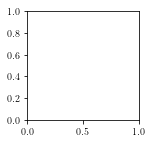

In [2]:
fig = plt.figure(figsize=(2, 2))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(1, 1, 1)

In [3]:
job_dir = 'ecoC01B05_wt0.9_psi-0a'
table_name = 'ecoC01B05_tao1_wm0.9'
t_headle = '(.*?).pickle'

In [4]:
t_dir = os.path.join(PWD, job_dir)

data = spf_tb.load_table_data_pickle_dir(t_dir, t_headle)
lst_eta = data.lst_eta
theta_max_fre = data.theta_max_fre
phi_max_fre = data.phi_max_fre
psi_max_fre = data.psi_max_fre
eta_max_fre = data.eta_max_fre
data_idx = data.data_idx.fillna(-1).astype(int)


2.0 1031


True

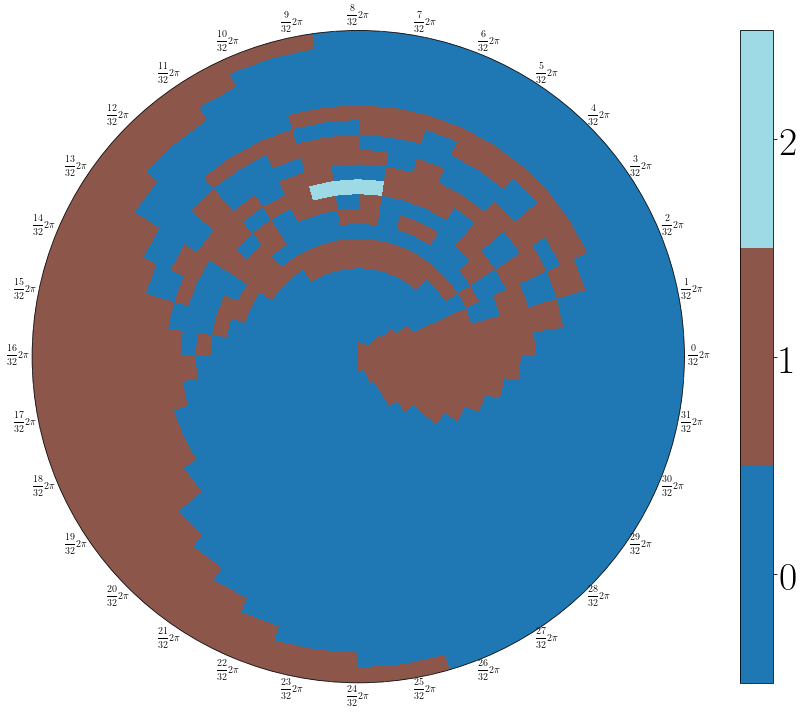

In [5]:
# put images with same frequence into a subdirect
check_fre_list = [0.0150]
atol_fre_list =  [0.0002]
Table_t_range = np.array((4500, np.inf))

def sub_seperate_a(i1, type_fre, iidx, Table_t_range):
    t1 = np.zeros_like(iidx[0])
    return t1

def sub_seperate_1(i1, type_fre, iidx, Table_t_range):
    theta = type_fre.index.values[iidx[0]]
    phi = type_fre.columns.values[iidx[1]]
    theta_phi_list = np.vstack((theta, phi)).T
    tuse = []
    for theta, phi in tqdm_notebook(theta_phi_list, desc='No. %d  ' % i1):
        tpick, _ = spf_tb.load_table_date_pickle(job_dir, theta, phi)
        Table_t = tpick['Table_t']
        Table_theta = tpick['Table_theta']
        Table_phi = tpick['Table_phi']
        Table_psi = tpick['Table_psi']
        
        idx = np.logical_and(Table_t >= Table_t_range[0], Table_t <= Table_t_range[1])
        tuse.append(np.max(Table_psi[idx]))
    tuse = np.hstack(tuse)
    t1 = np.ones_like(tuse)
    t1[tuse > np.pi] = 0
    return t1

def sub_seperate_other(i1, type_fre, iidx, Table_t_range):
    theta = type_fre.index.values[iidx[0]]
    phi = type_fre.columns.values[iidx[1]]
    theta_phi_list = np.vstack((theta, phi)).T
    tuse = []
    for theta, phi in tqdm_notebook(theta_phi_list, desc='No. %d  ' % i1):
        tpick, _ = spf_tb.load_table_date_pickle(job_dir, theta, phi)
        Table_t = tpick['Table_t']
        Table_theta = tpick['Table_theta']
        Table_phi = tpick['Table_phi']
        Table_psi = tpick['Table_psi']
        
        idx = np.logical_and(Table_t >= Table_t_range[0], Table_t <= Table_t_range[1])
        tuse.append(np.max(Table_phi[idx]))
    tuse = np.hstack(tuse)
    t1 = np.ones_like(tuse)
    t1[tuse < np.pi] = 0
    return t1
    
sub_seperate = {0: sub_seperate_1, 
                'other': sub_seperate_other, }

tfre = theta_max_fre.copy()
type_fre = tfre.copy()
type_fre.iloc[:, :] = -1
i0 = 0
process_total = 0
for i1, (check_fre, atol_fre) in enumerate(zip(check_fre_list[:], atol_fre_list)):
    use_idx = np.isclose(tfre, check_fre, rtol=0, atol=atol_fre)
    iidx = np.where(use_idx)
    process_total = process_total + np.sum(use_idx)
    t1 = sub_seperate[i1](i1, type_fre, iidx, Table_t_range)
    type_fre.iloc[use_idx] = i0 + t1
    i0 = i0 + 1 + np.max(t1)
    print(i0, np.sum(use_idx))

# assert 1 == 2
# plot one of the remaind cases
if np.any(type_fre.values == -1):
    iidx = np.where(type_fre.values == -1)
    t1 = sub_seperate['other'](-1, type_fre, iidx, Table_t_range)
    for (i3, i4), t11 in zip(np.vstack(iidx).T, t1):
        type_fre.iloc[i3].iloc[i4] = i0 + t11

assert np.all(type_fre.values >= 0)
type_fre2 = type_fre.copy()
type_fre2.iloc[type_fre.values == 0] = 0
type_fre2.iloc[type_fre.values == 1] = 1
type_fre2.iloc[type_fre.values == 2] = 2
type_fre2.iloc[type_fre.values == 3] = 1
spf_tb.show_traj_phase_map_type(type_fre2)
# spf_tb.save_separate_angleList_fft(job_dir, tfre, check_fre_list, atol_fre_list)

In [6]:
t1 = []
for i0 in np.arange(type_fre2.values.max() + 1):
    t1.append(np.isclose(type_fre2.values, i0).sum())

print(np.sum(t1))
print(t1)
print(t1 / np.sum(t1))

1035
[662, 370, 3]
[0.63961353 0.35748792 0.00289855]


-ini_theta 0.000000 -ini_phi 1.714000
-ini_theta 0.000000 -ini_phi 0.000000 -ini_psi 3.141593


/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


-ini_theta 0.000000 -ini_phi 0.000000
-ini_theta 0.000000 -ini_phi 0.000000 -ini_psi 0.000000


/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


-ini_theta 1.571000 -ini_phi 1.428000
-ini_theta 1.570796 -ini_phi 1.427997 -ini_psi 0.000000


/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


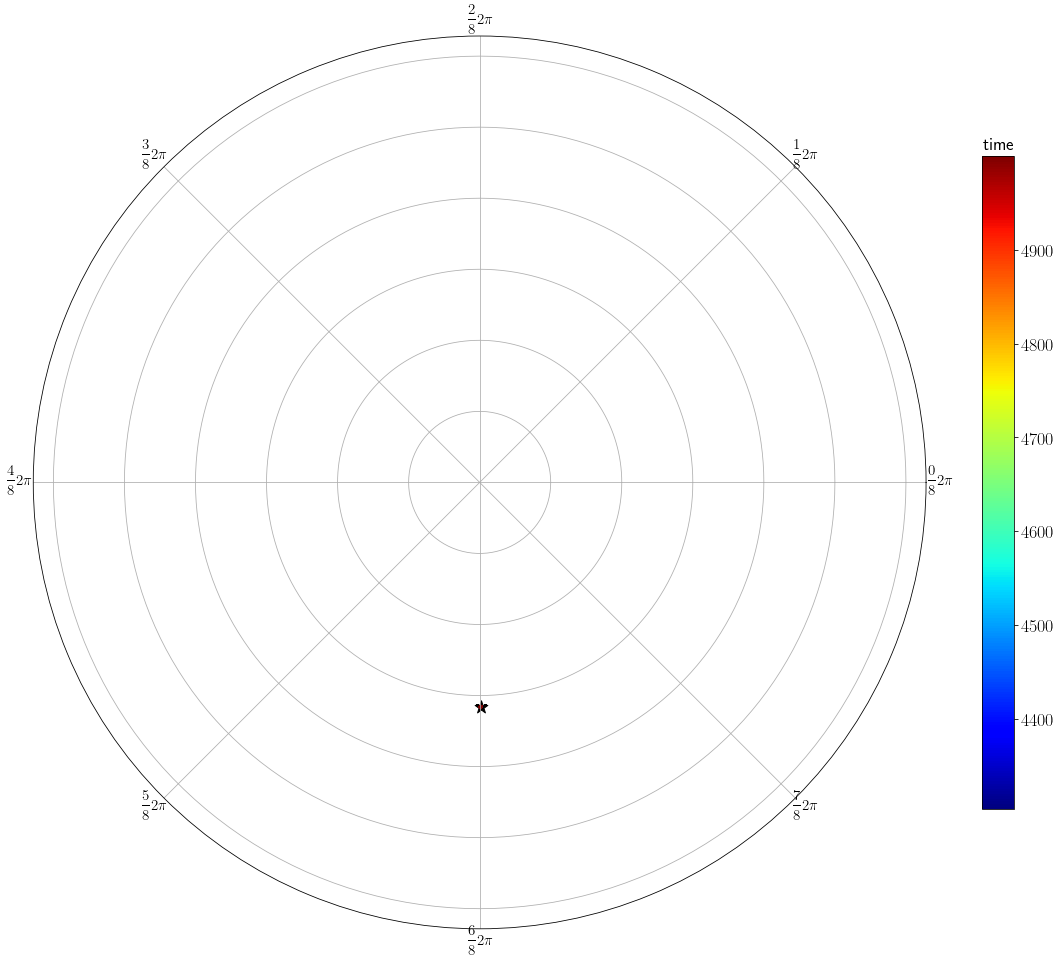

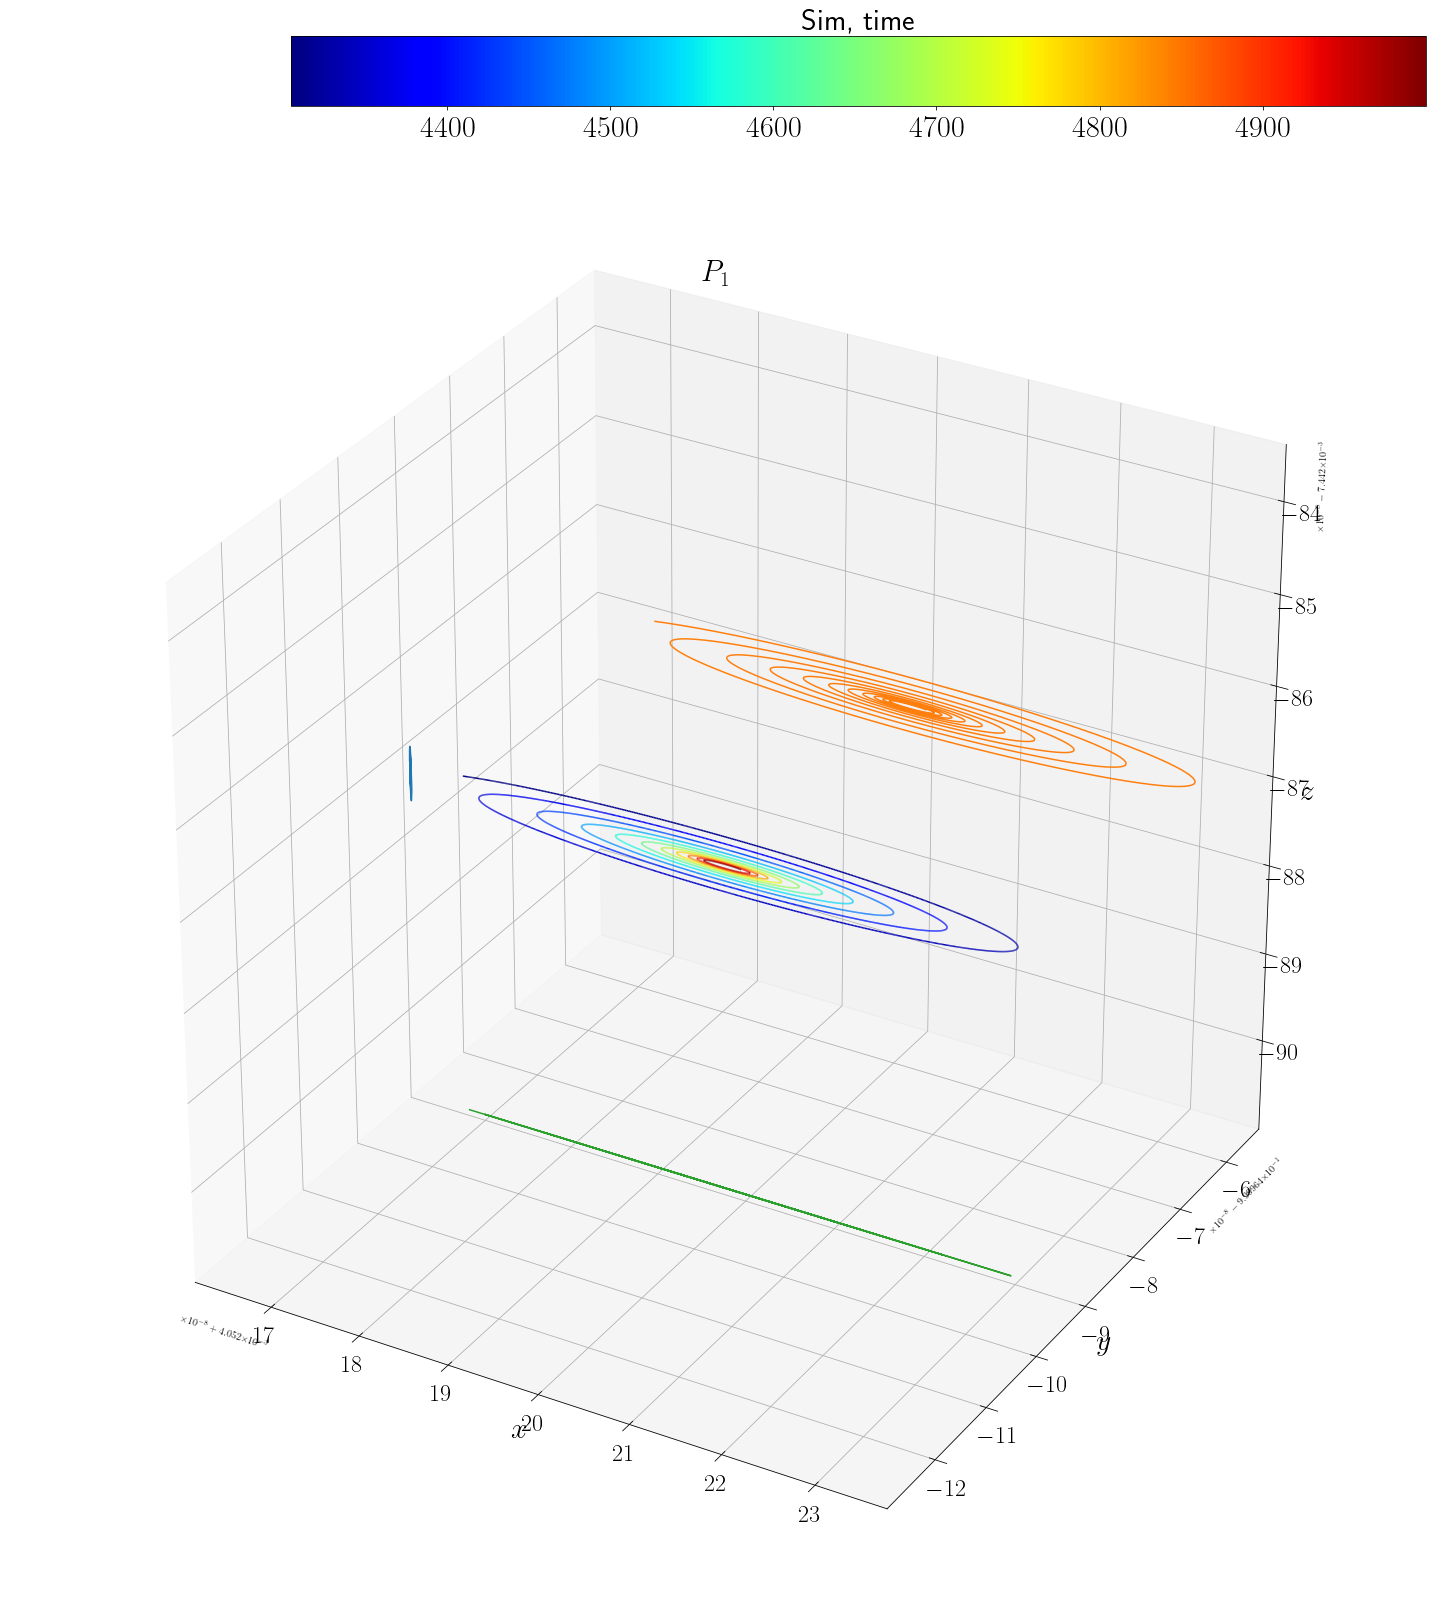

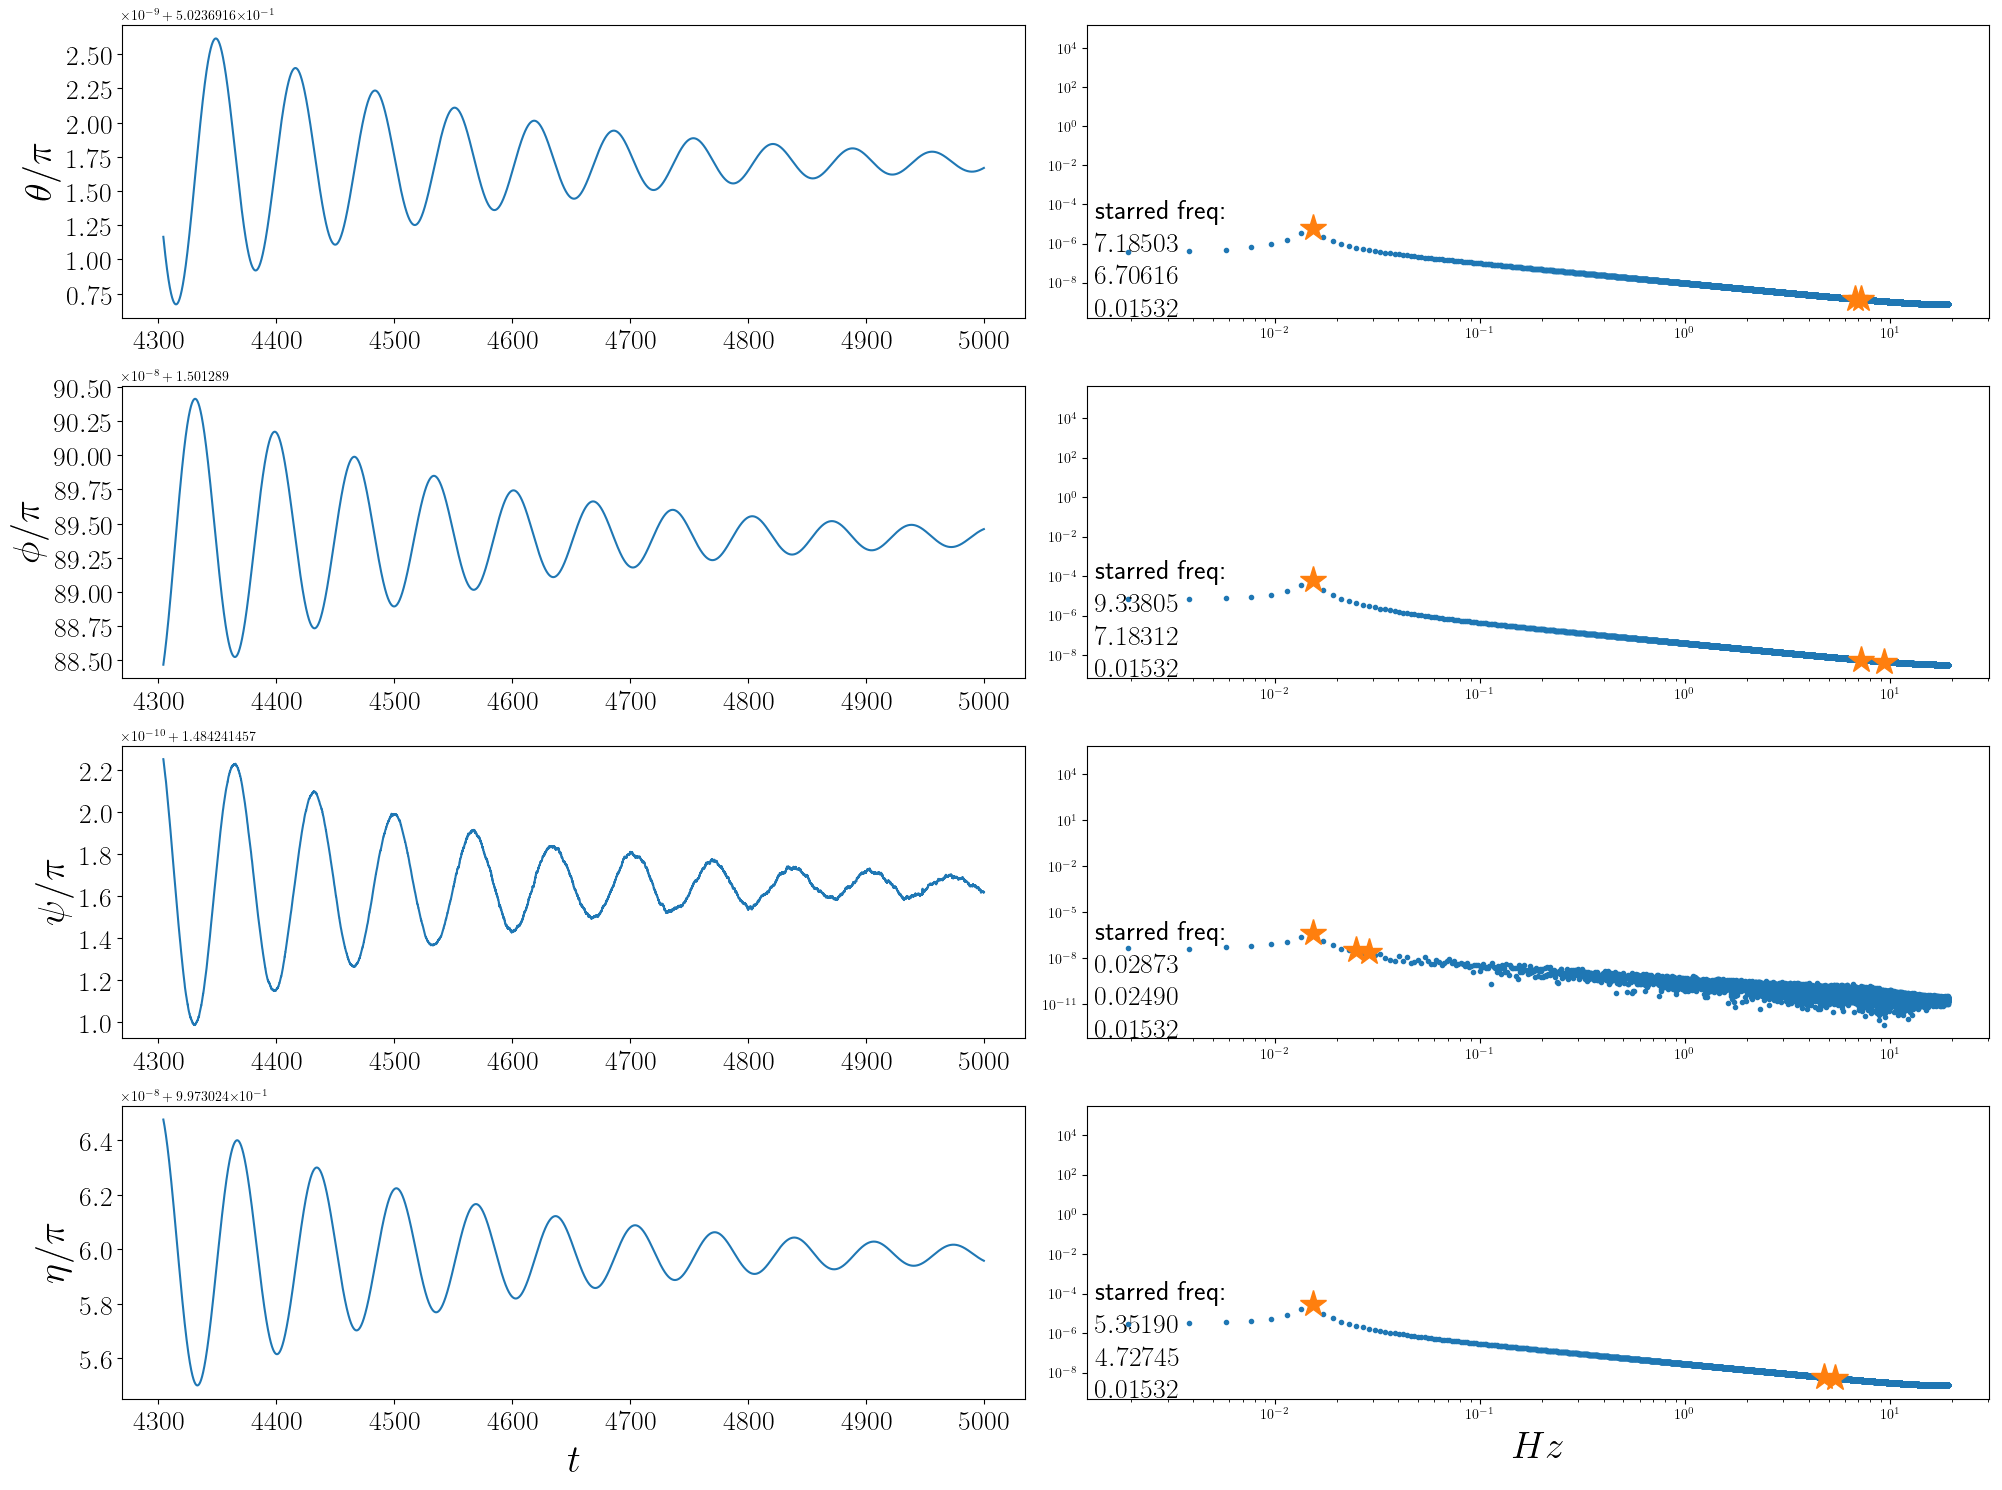

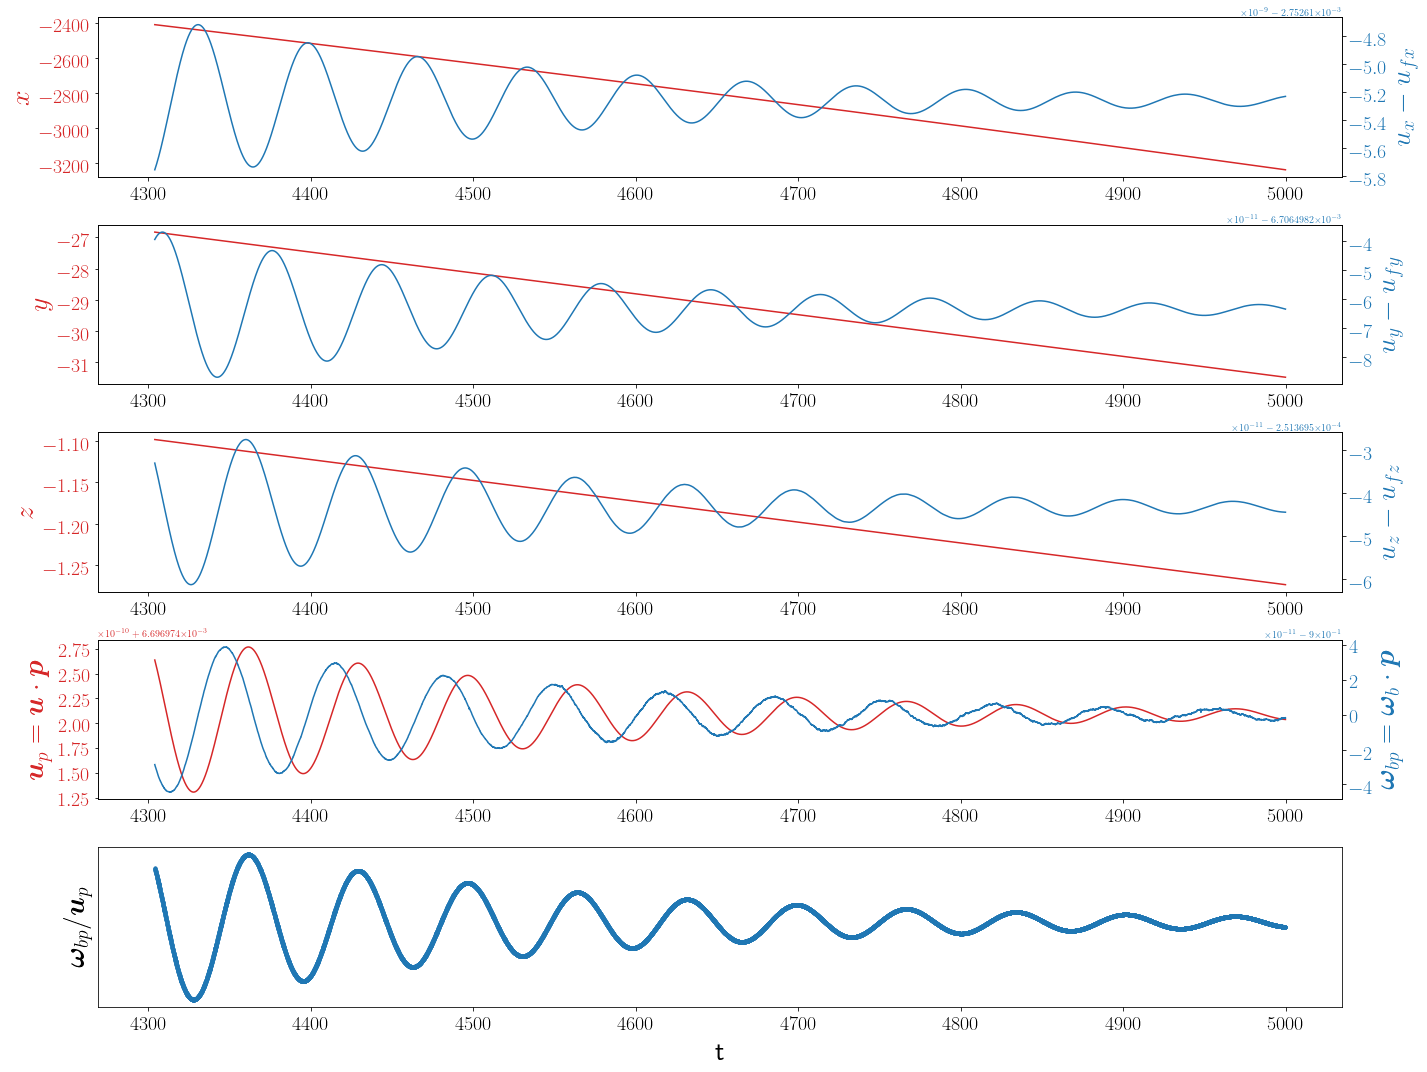

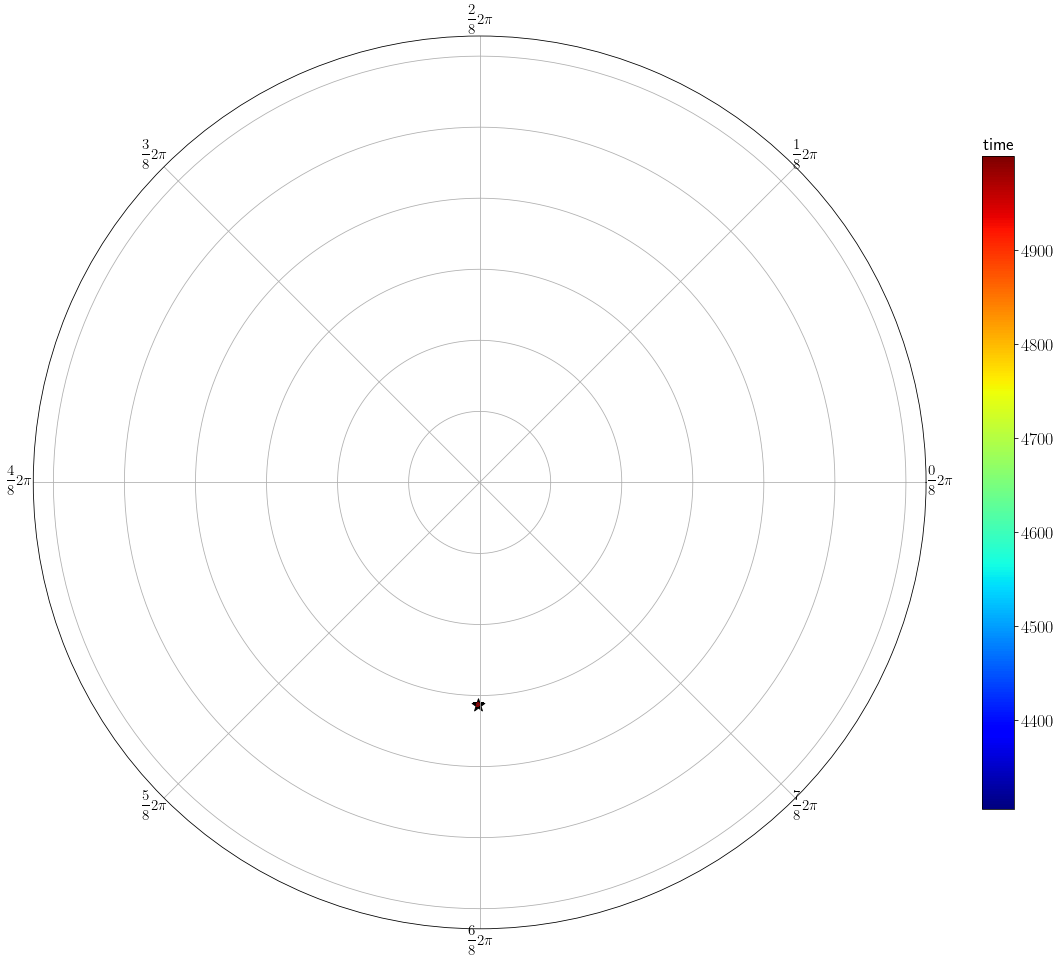

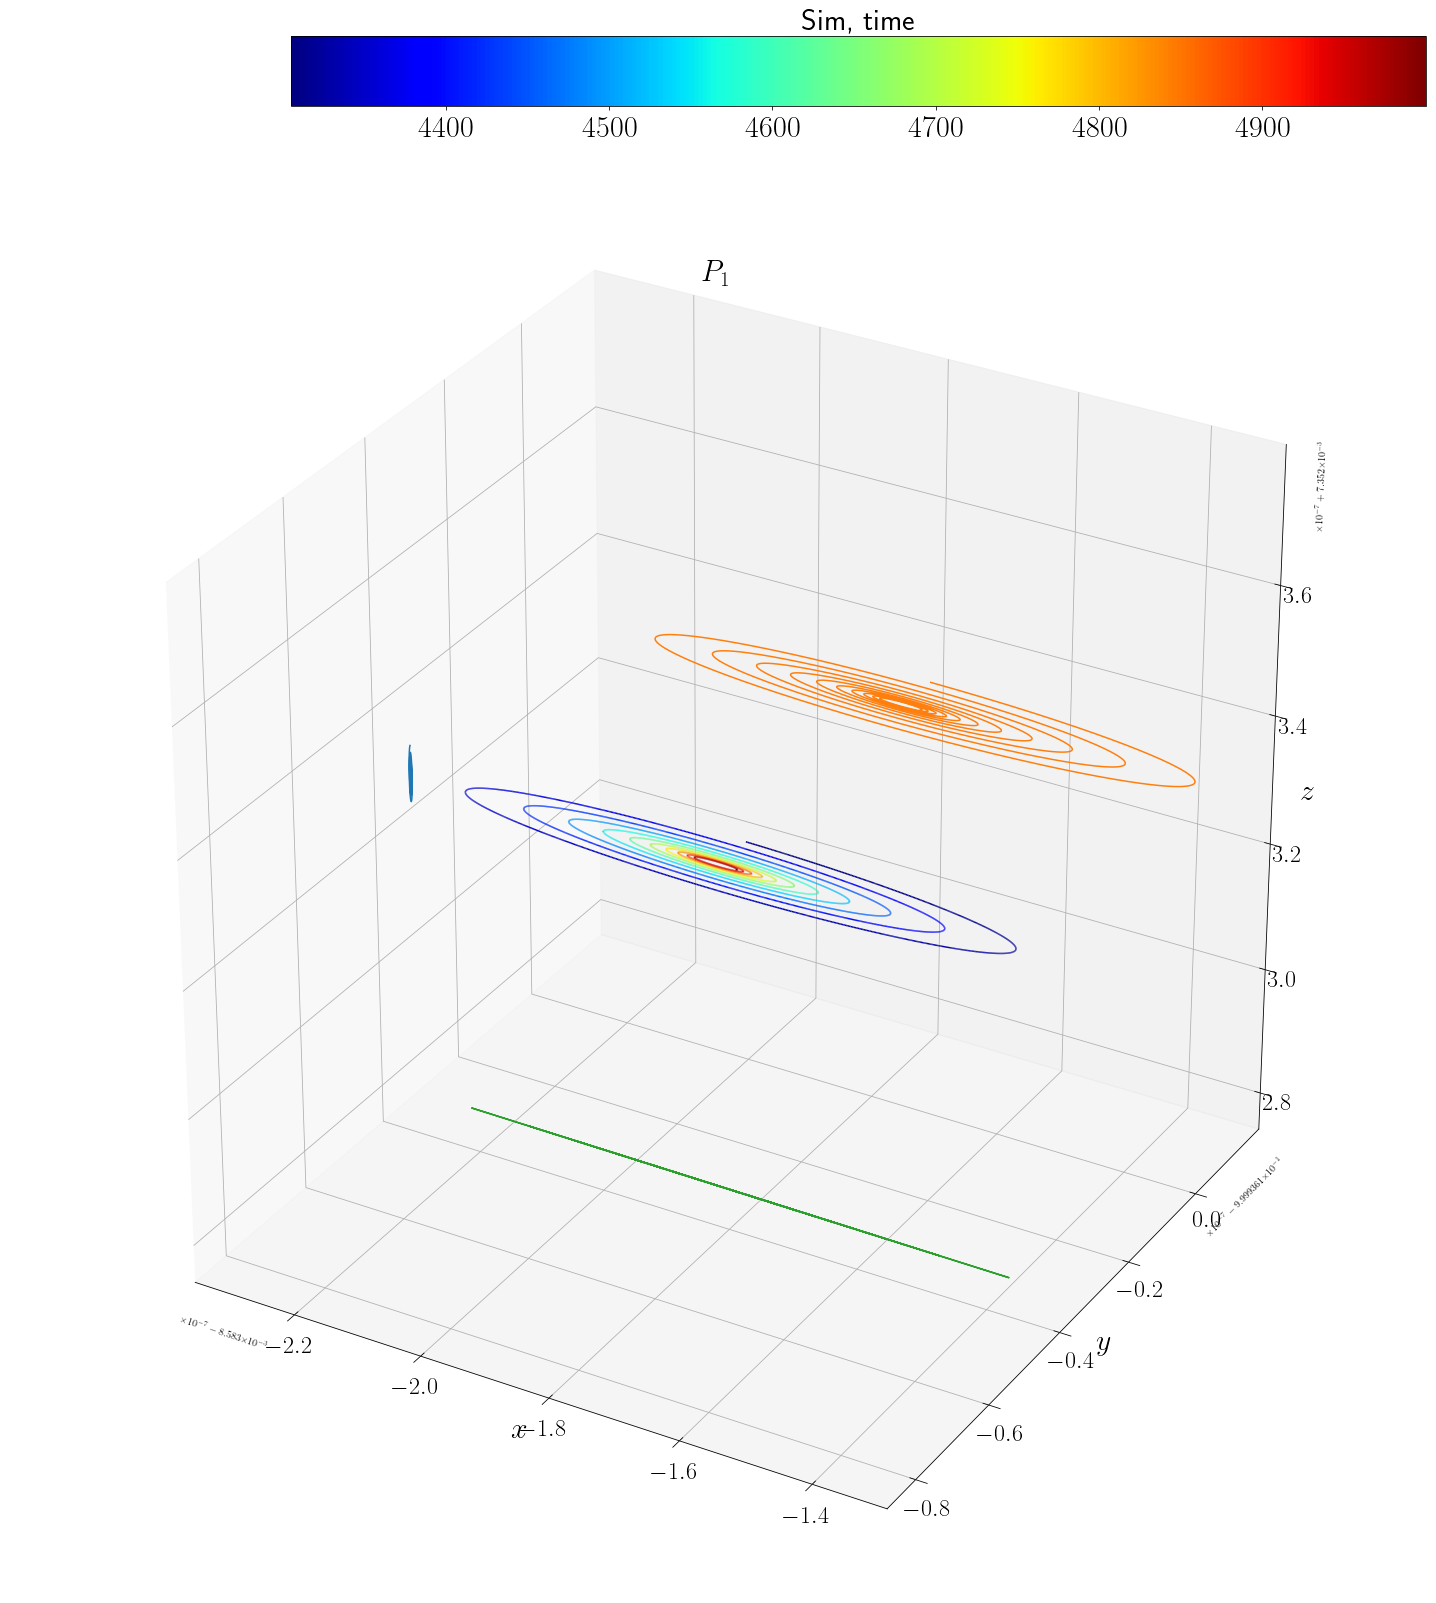

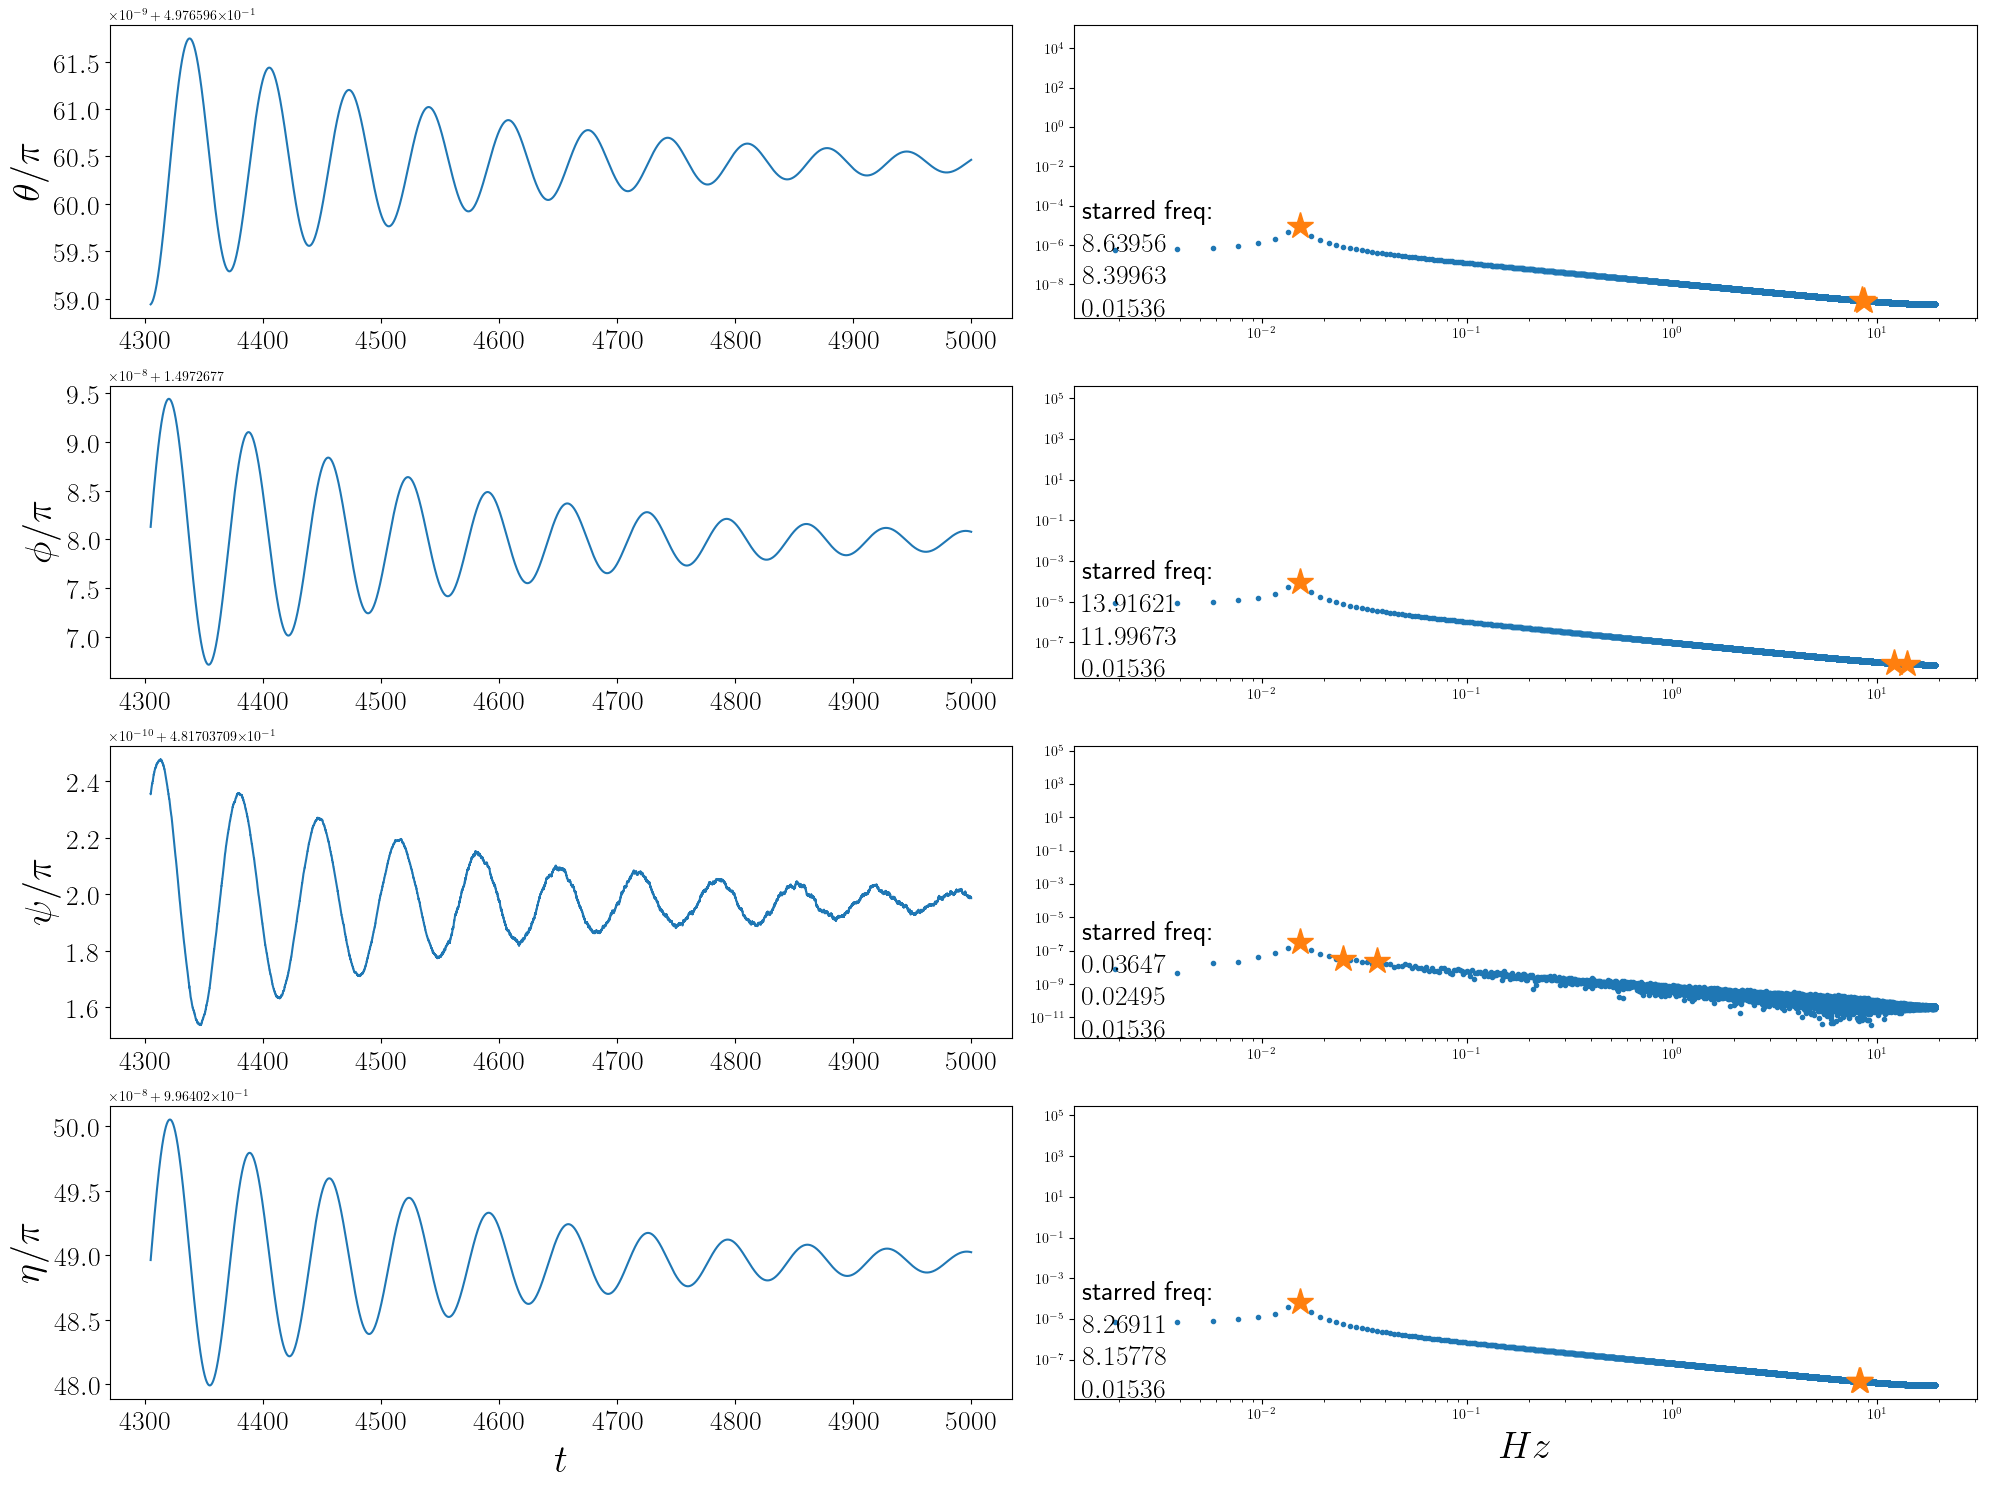

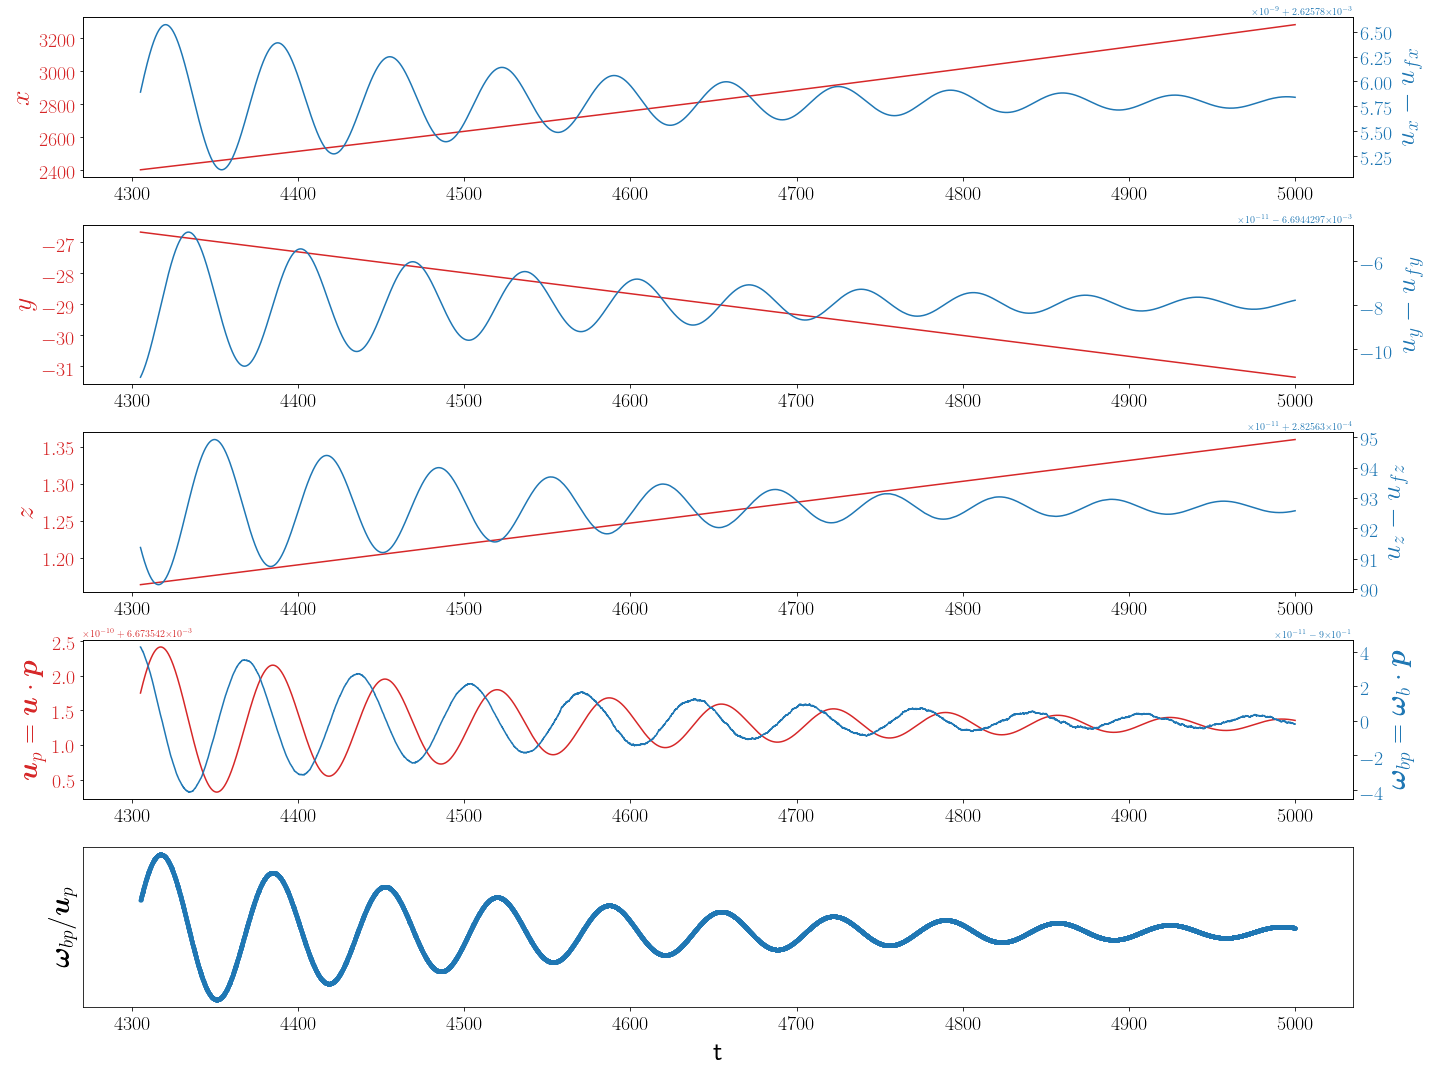

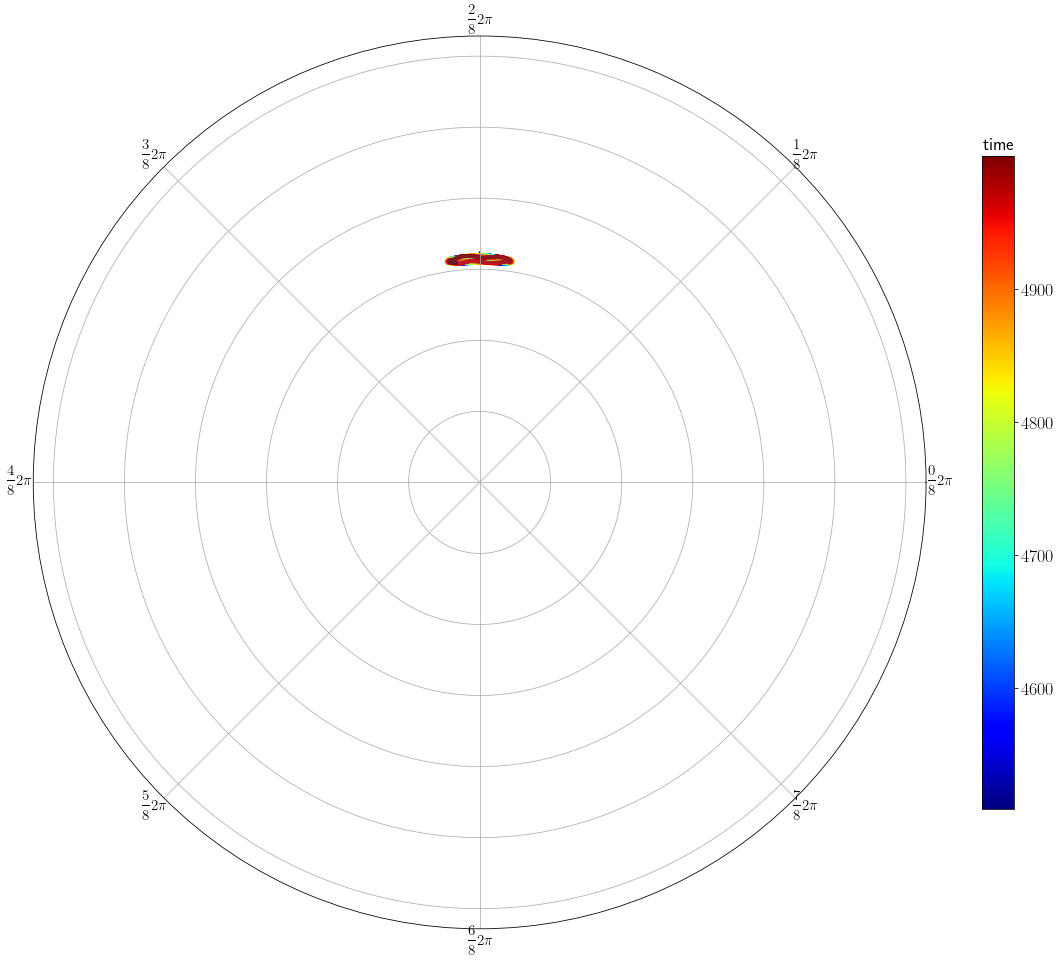

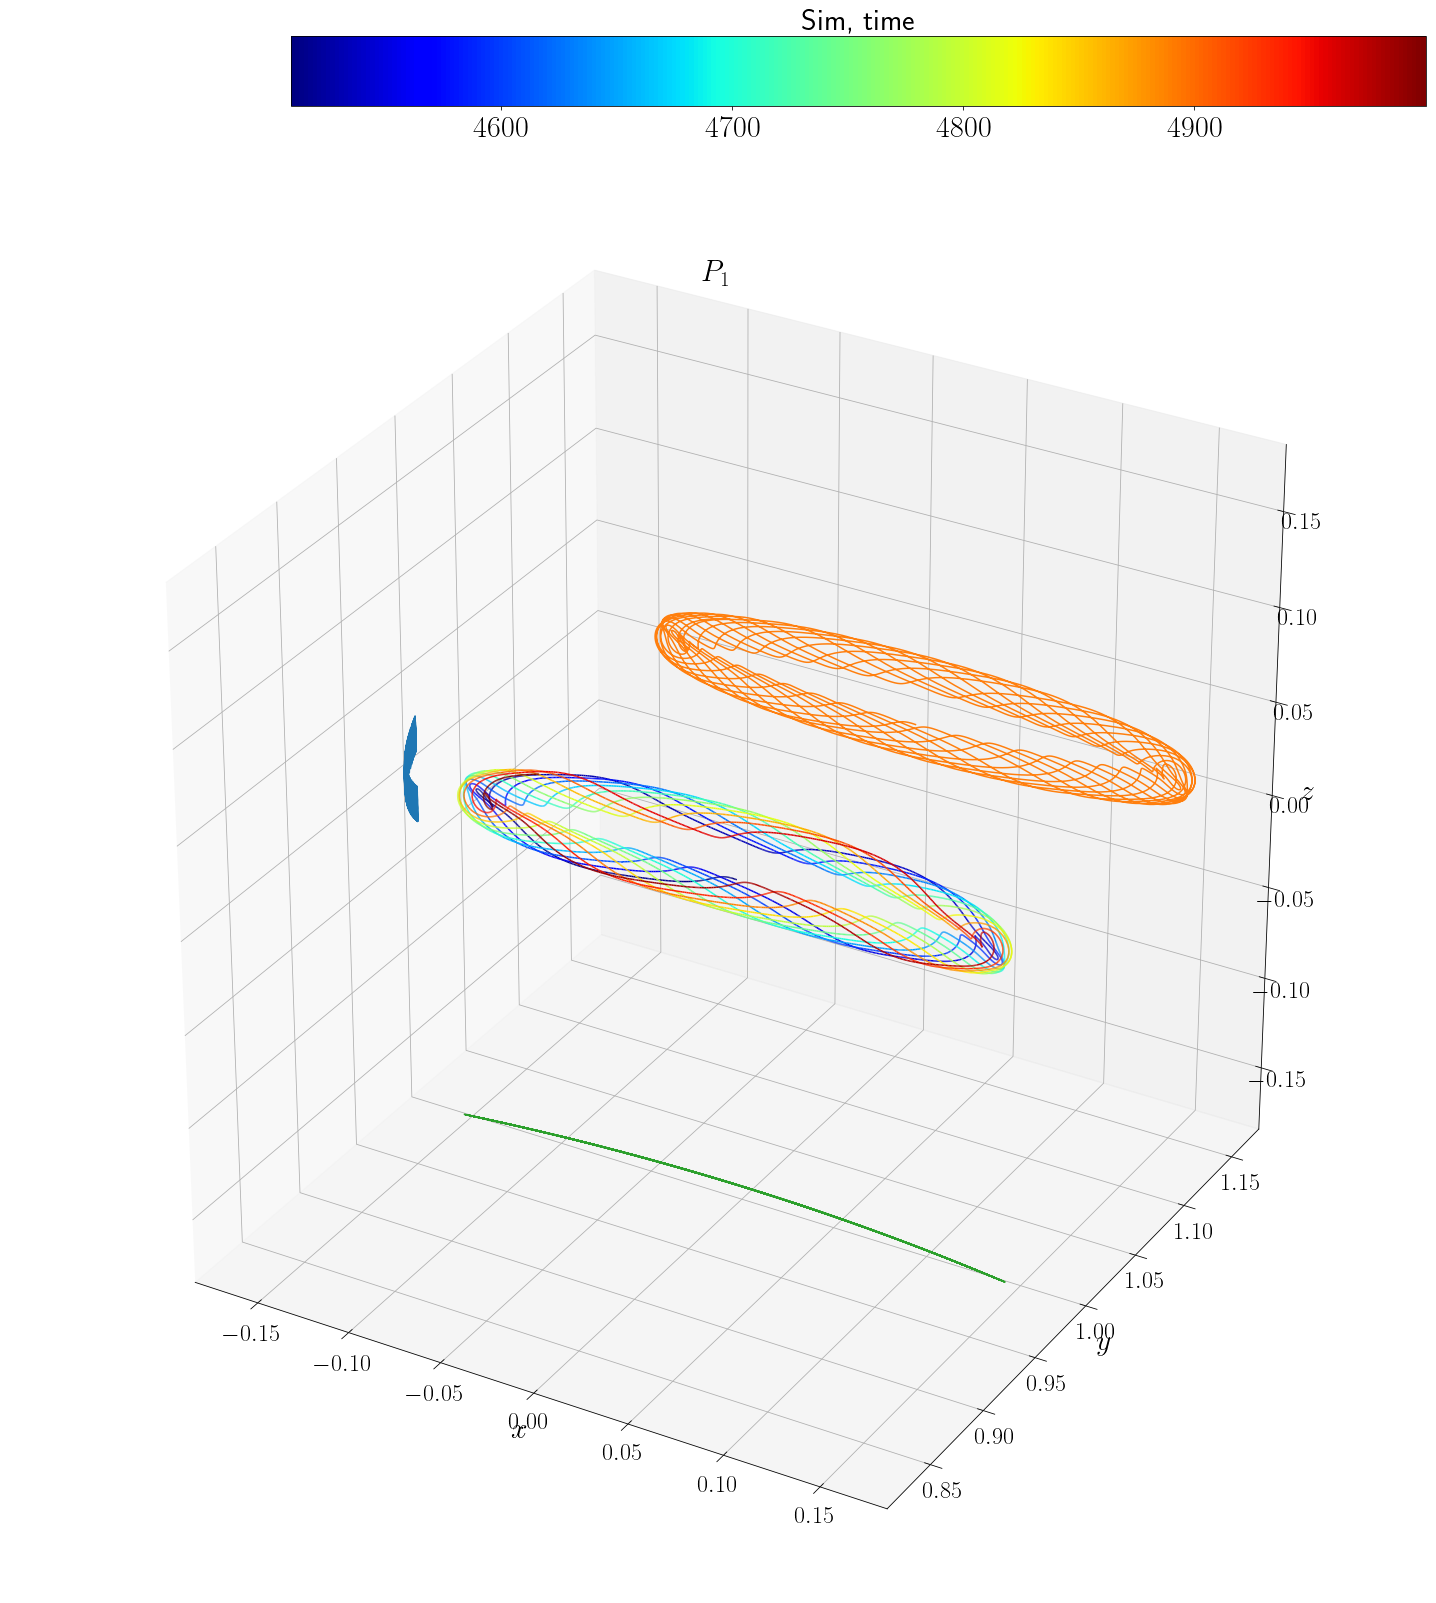

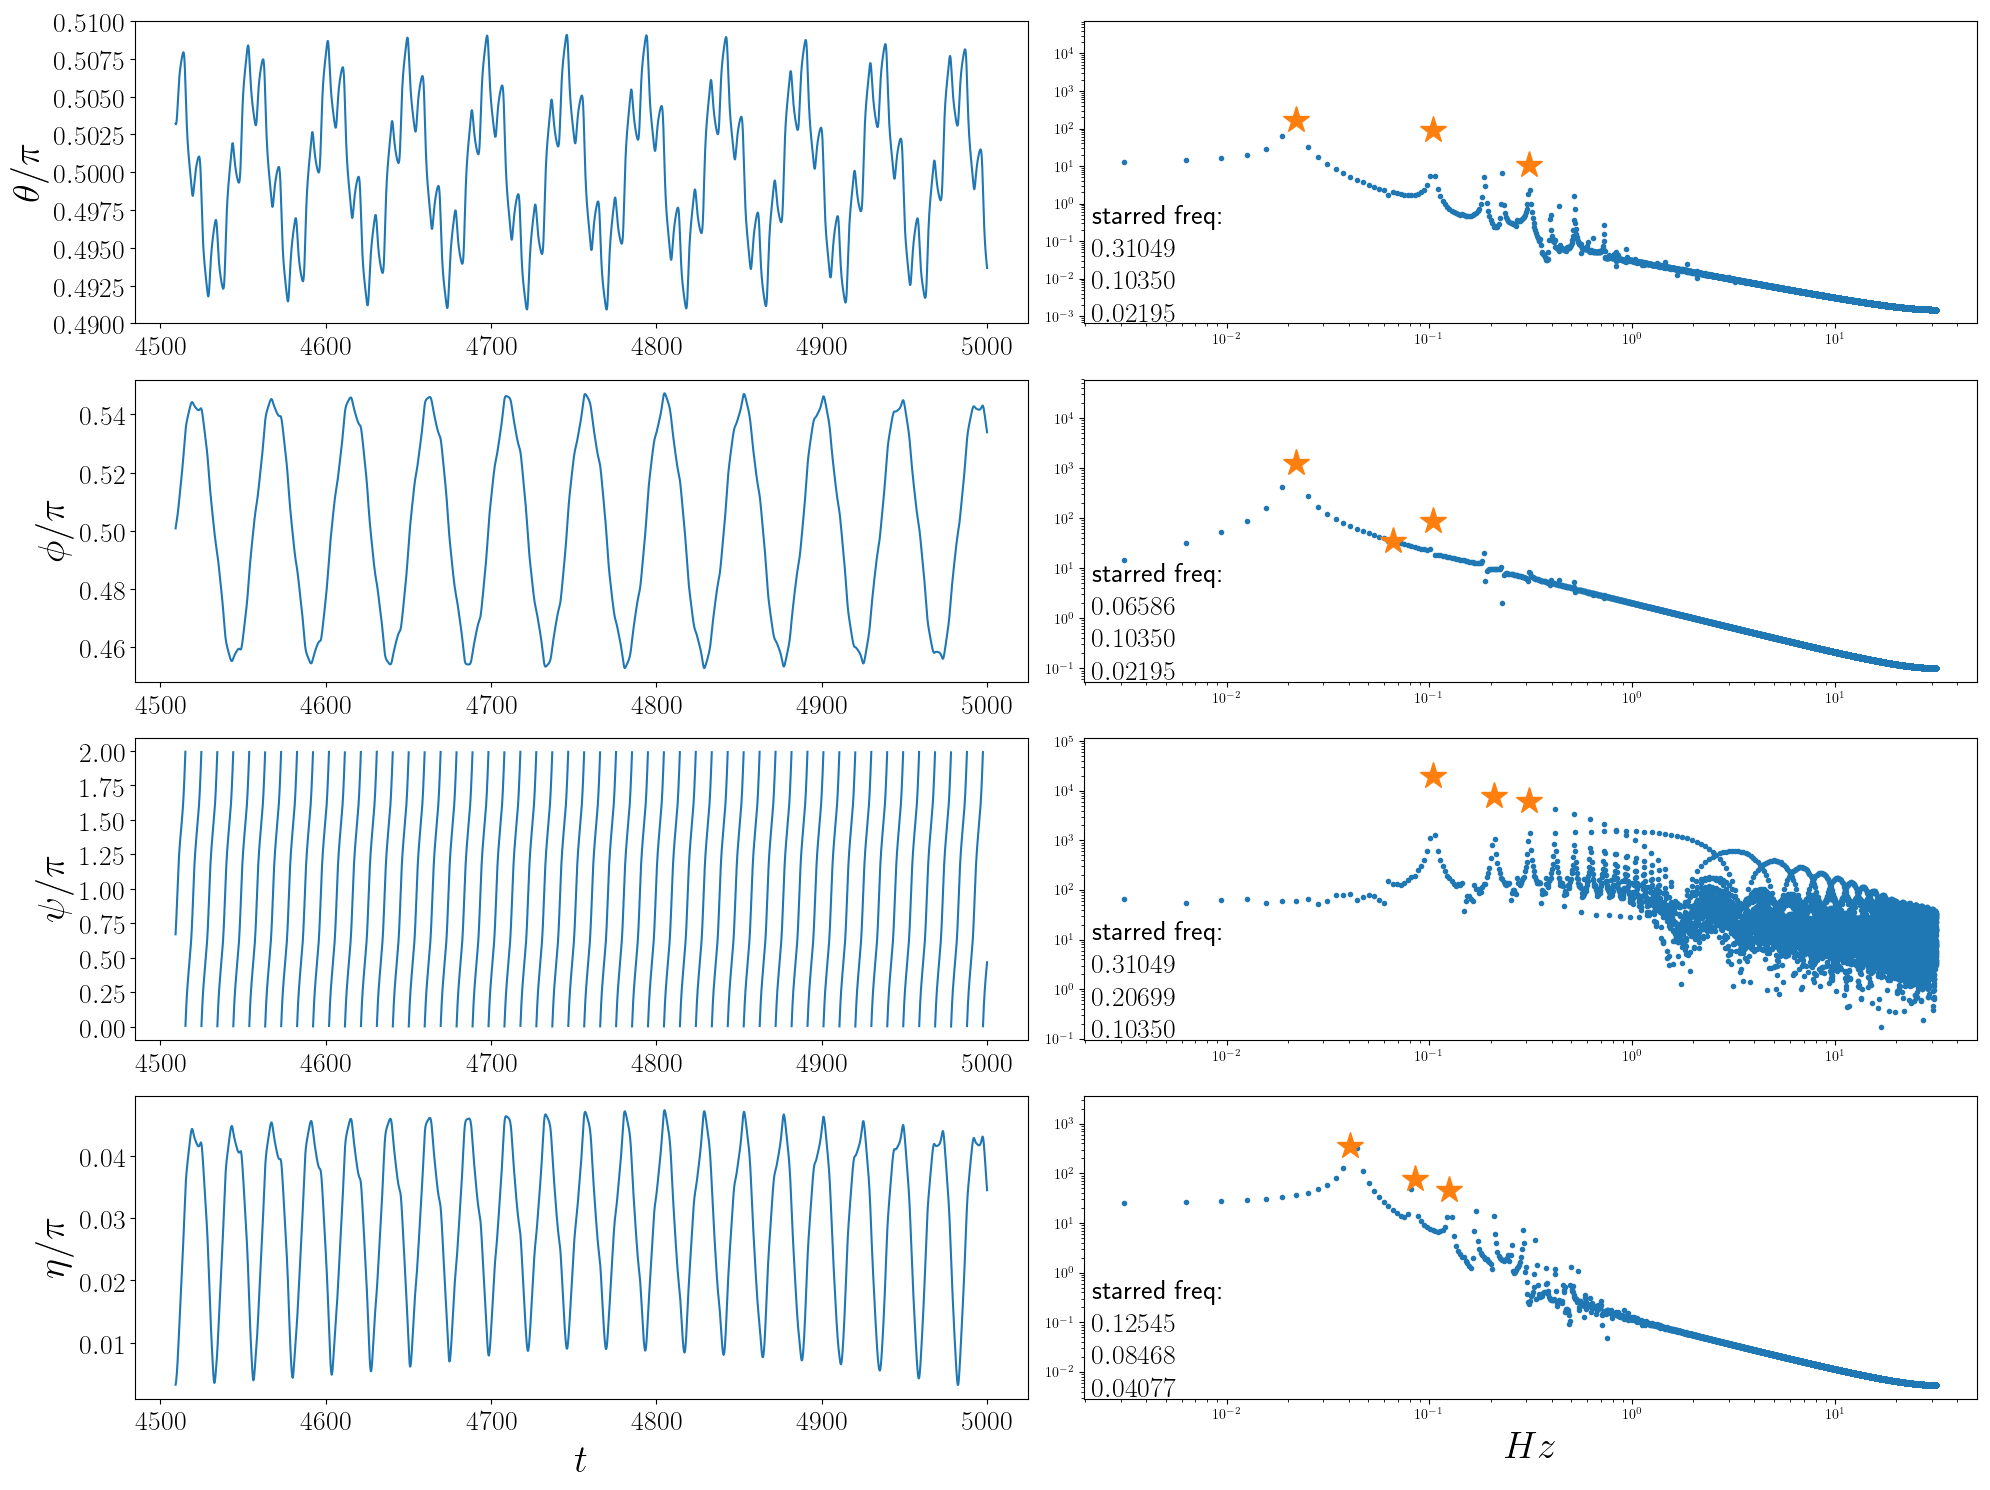

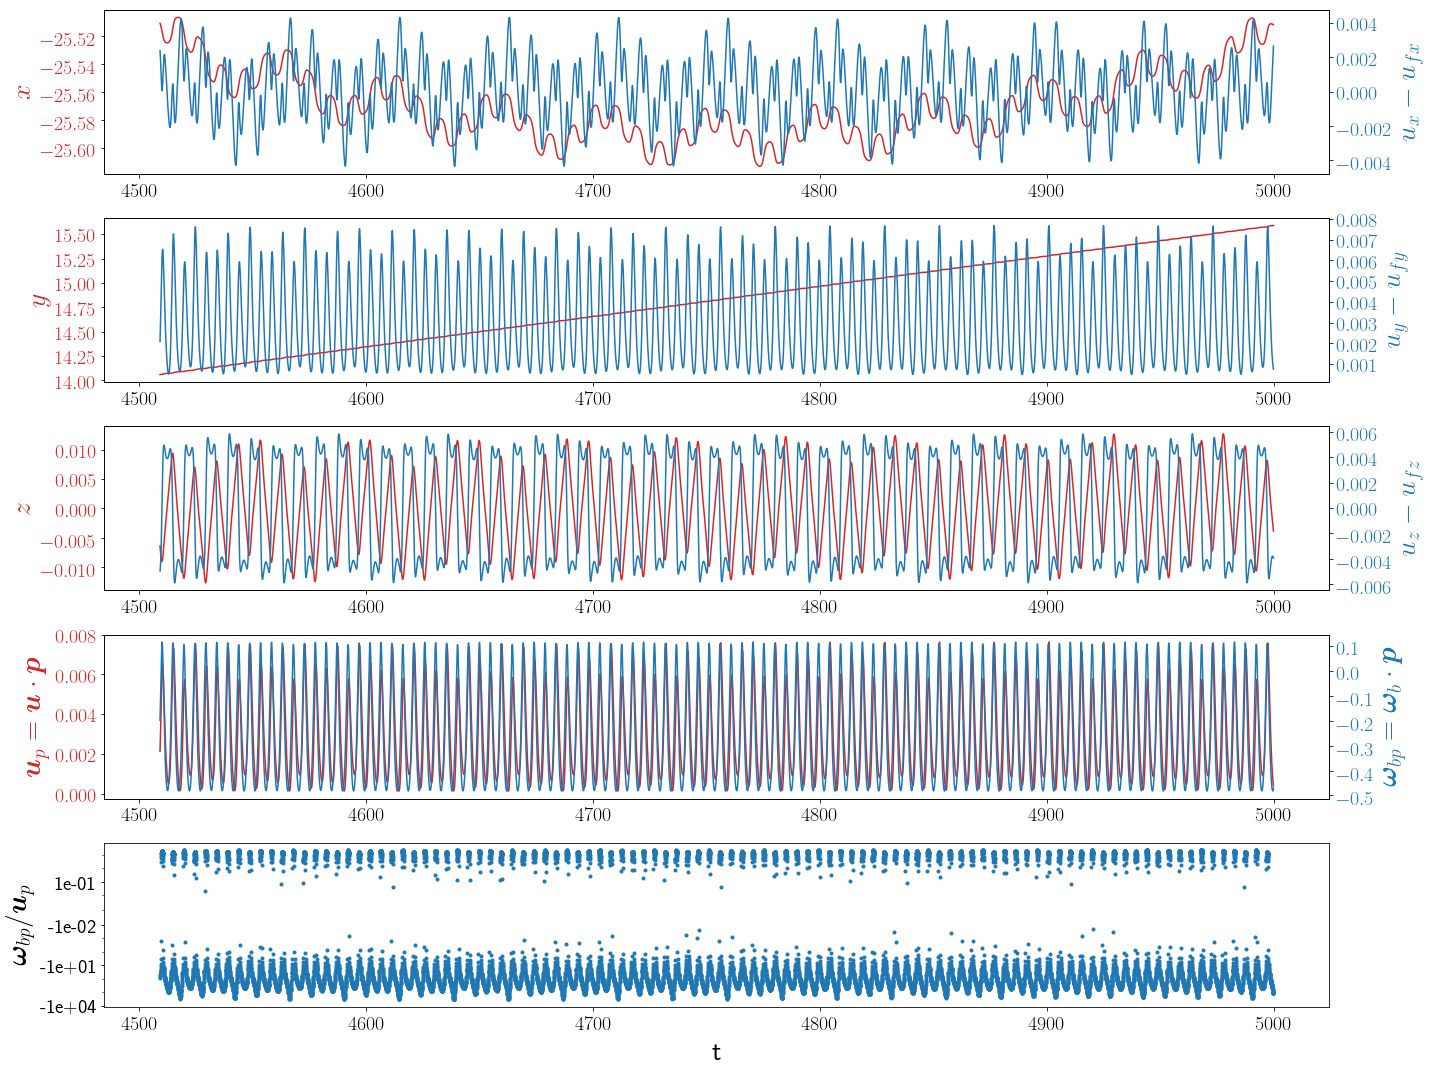

In [21]:
fast_mode1 = 0
figsize = np.array((16, 9)) * 0.5
dpi = 200

tipical_th_ph_list = []
for i0 in np.arange(type_fre2.values.max() + 1)[:]:
    iidx = np.where(np.isclose(type_fre2.values, i0))
    spf_tb.phase_map_show_idx(type_fre2, tipical_th_ph_list, iidx, job_dir, table_name, fast_mode=fast_mode1, )

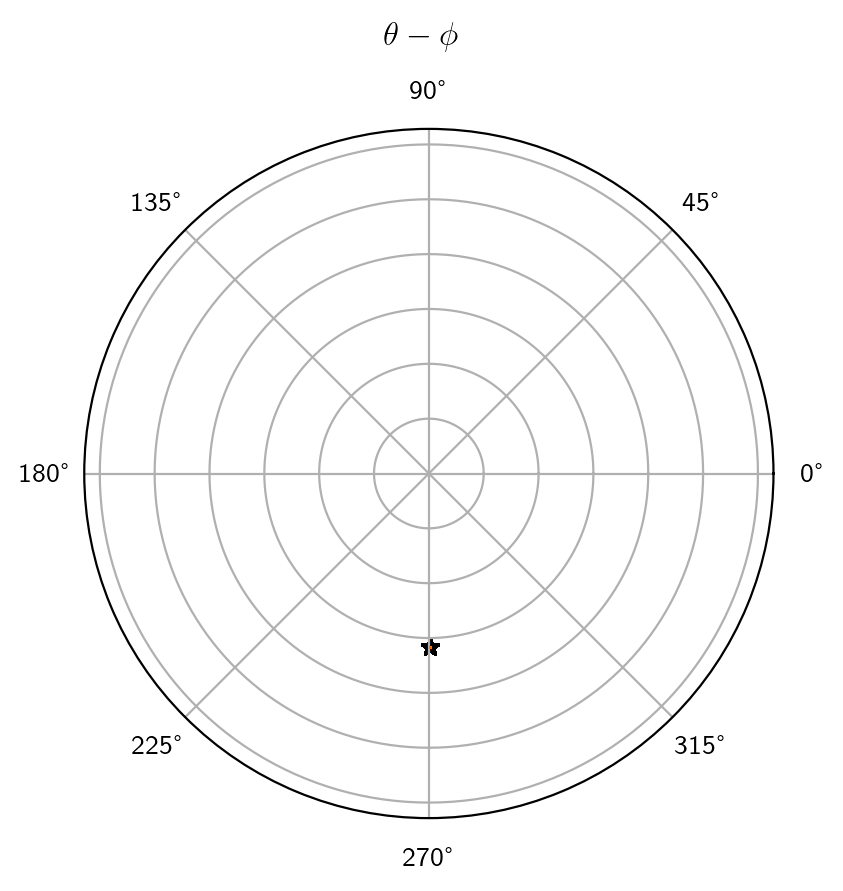

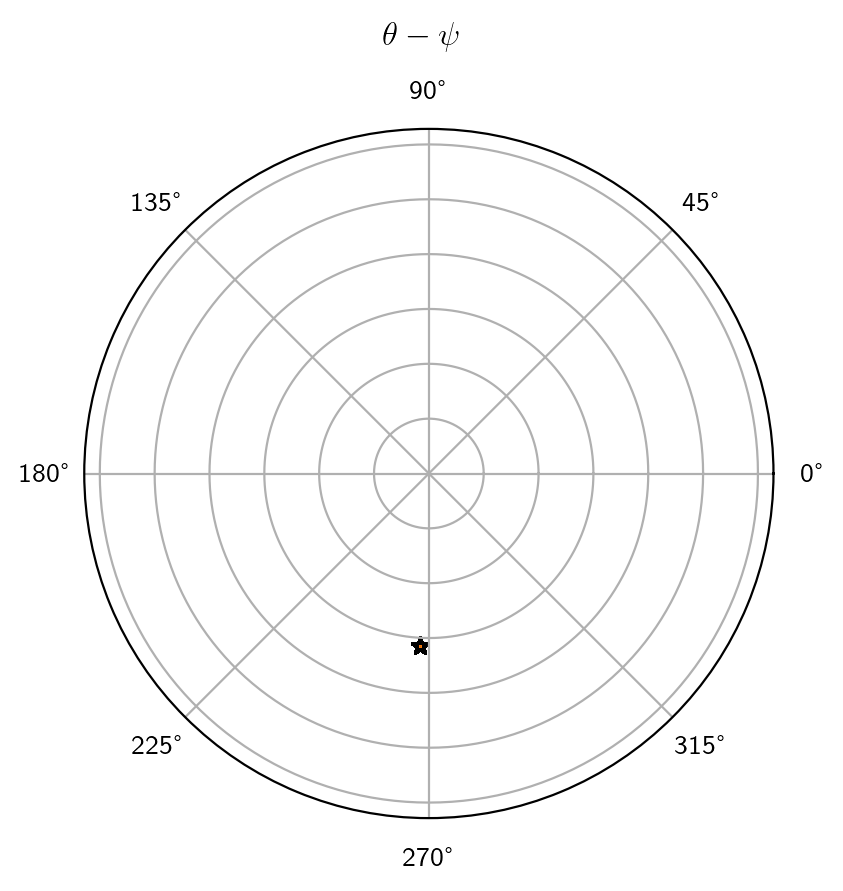

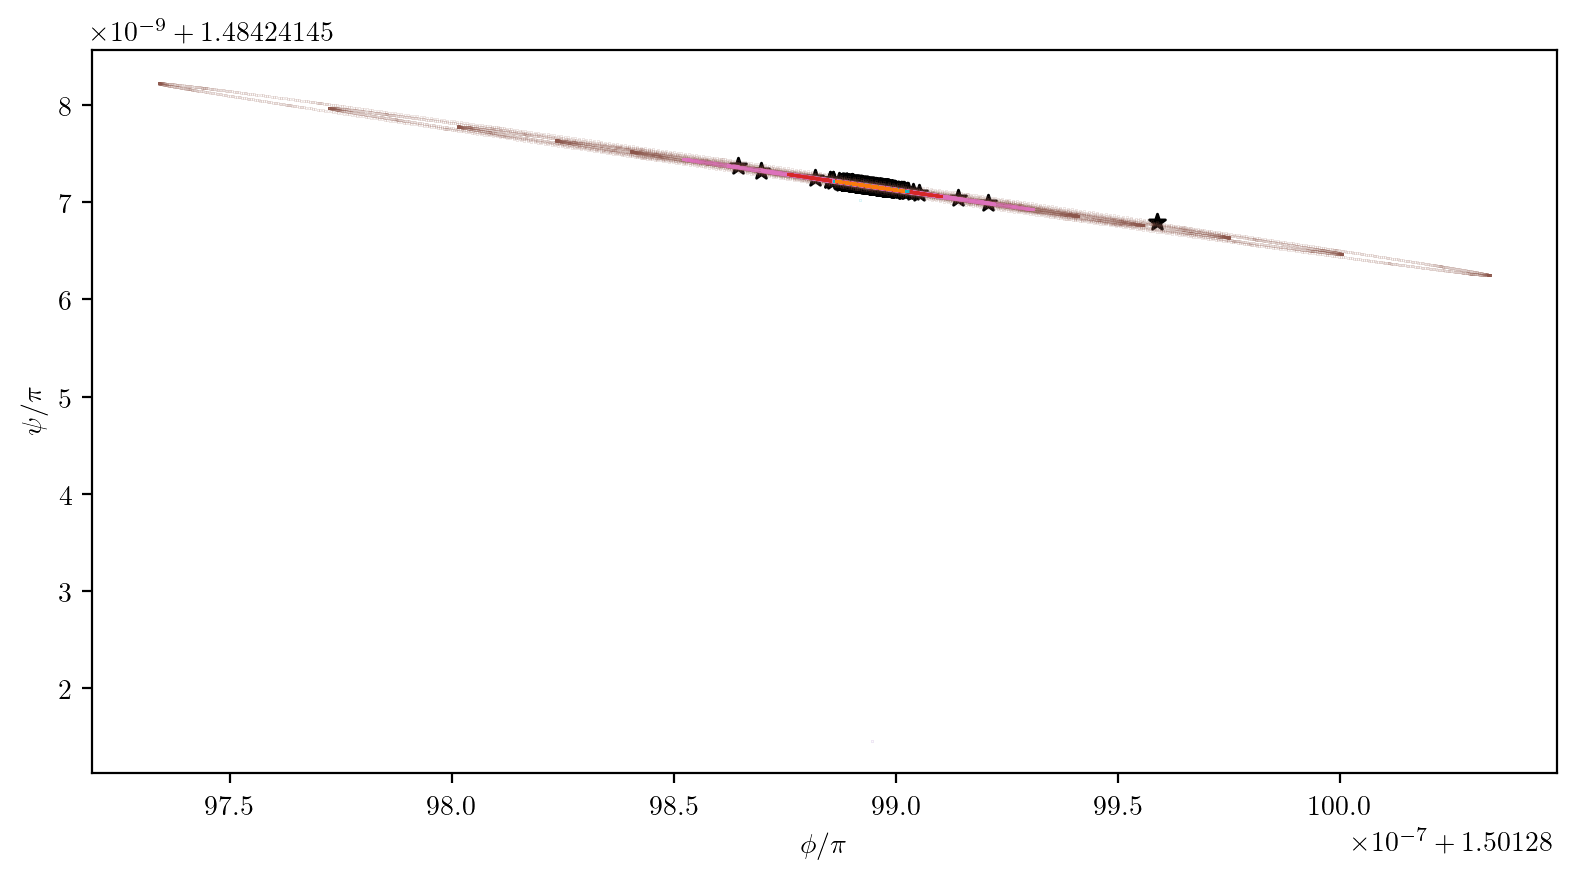

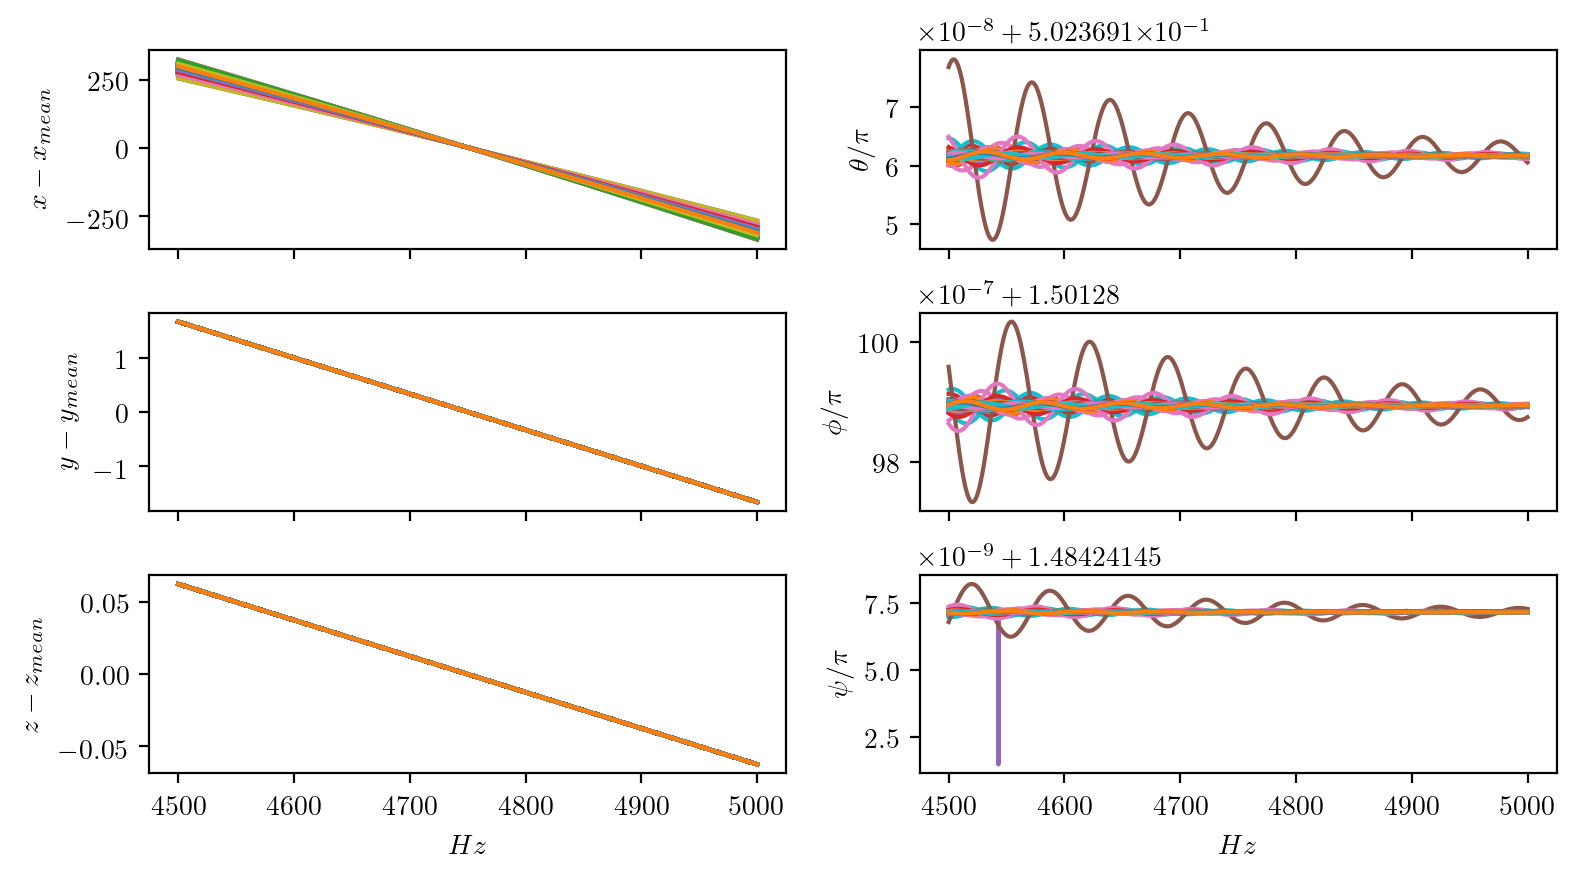

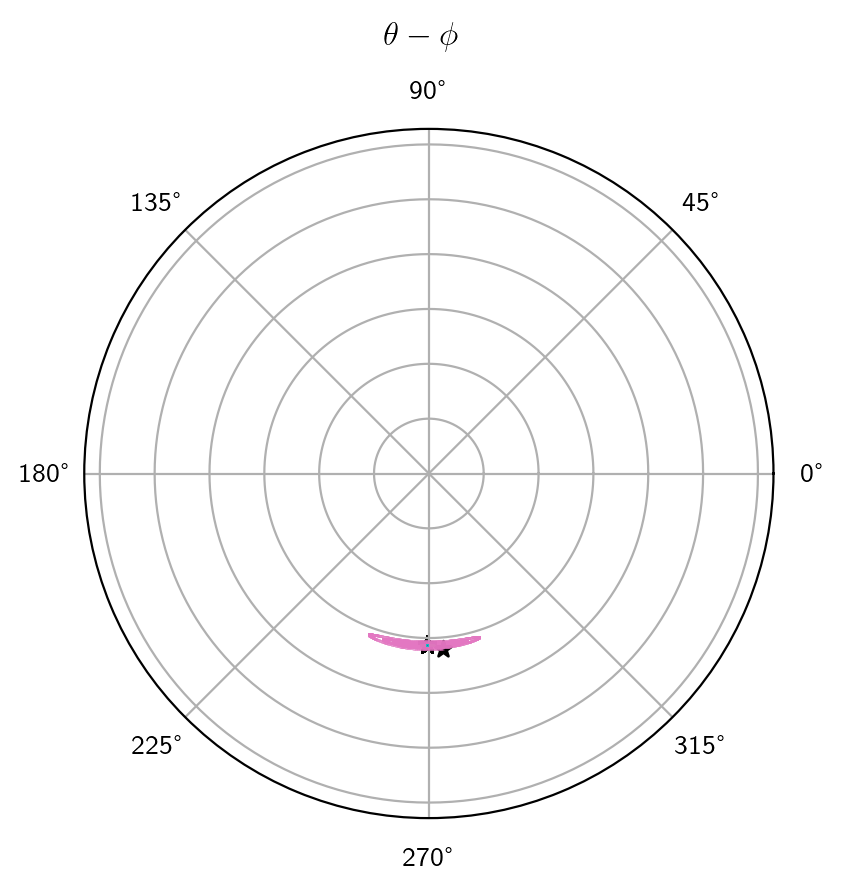

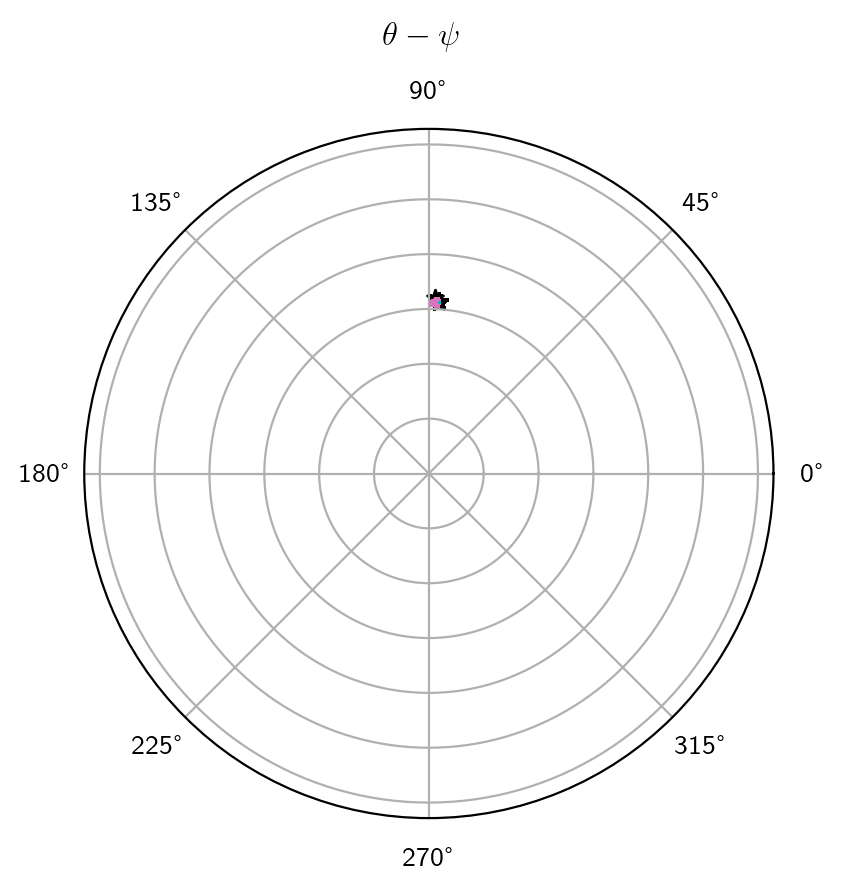

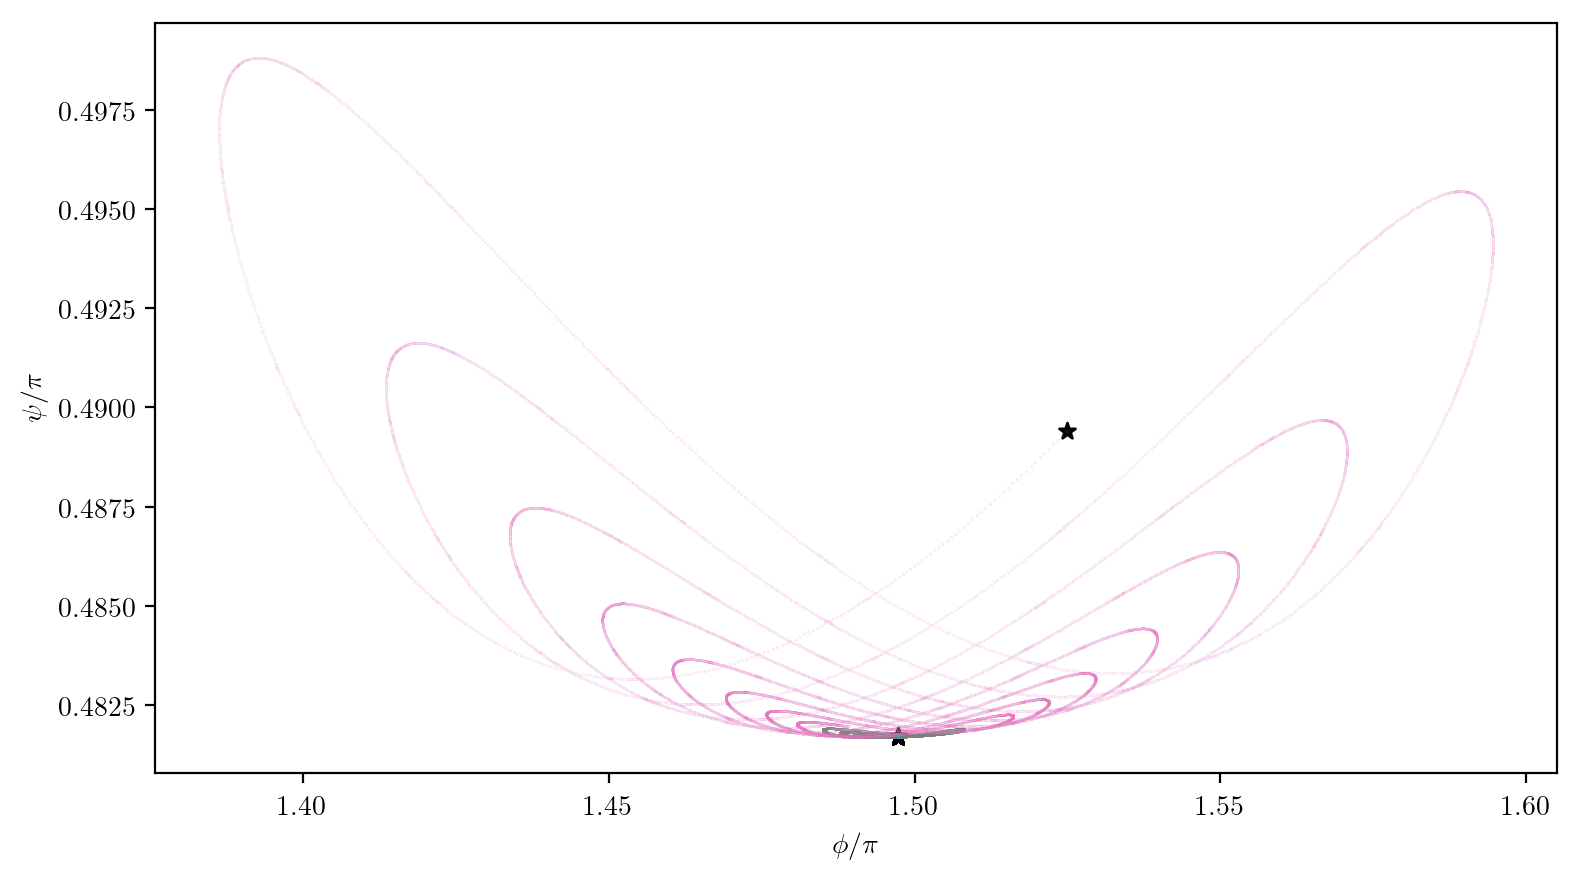

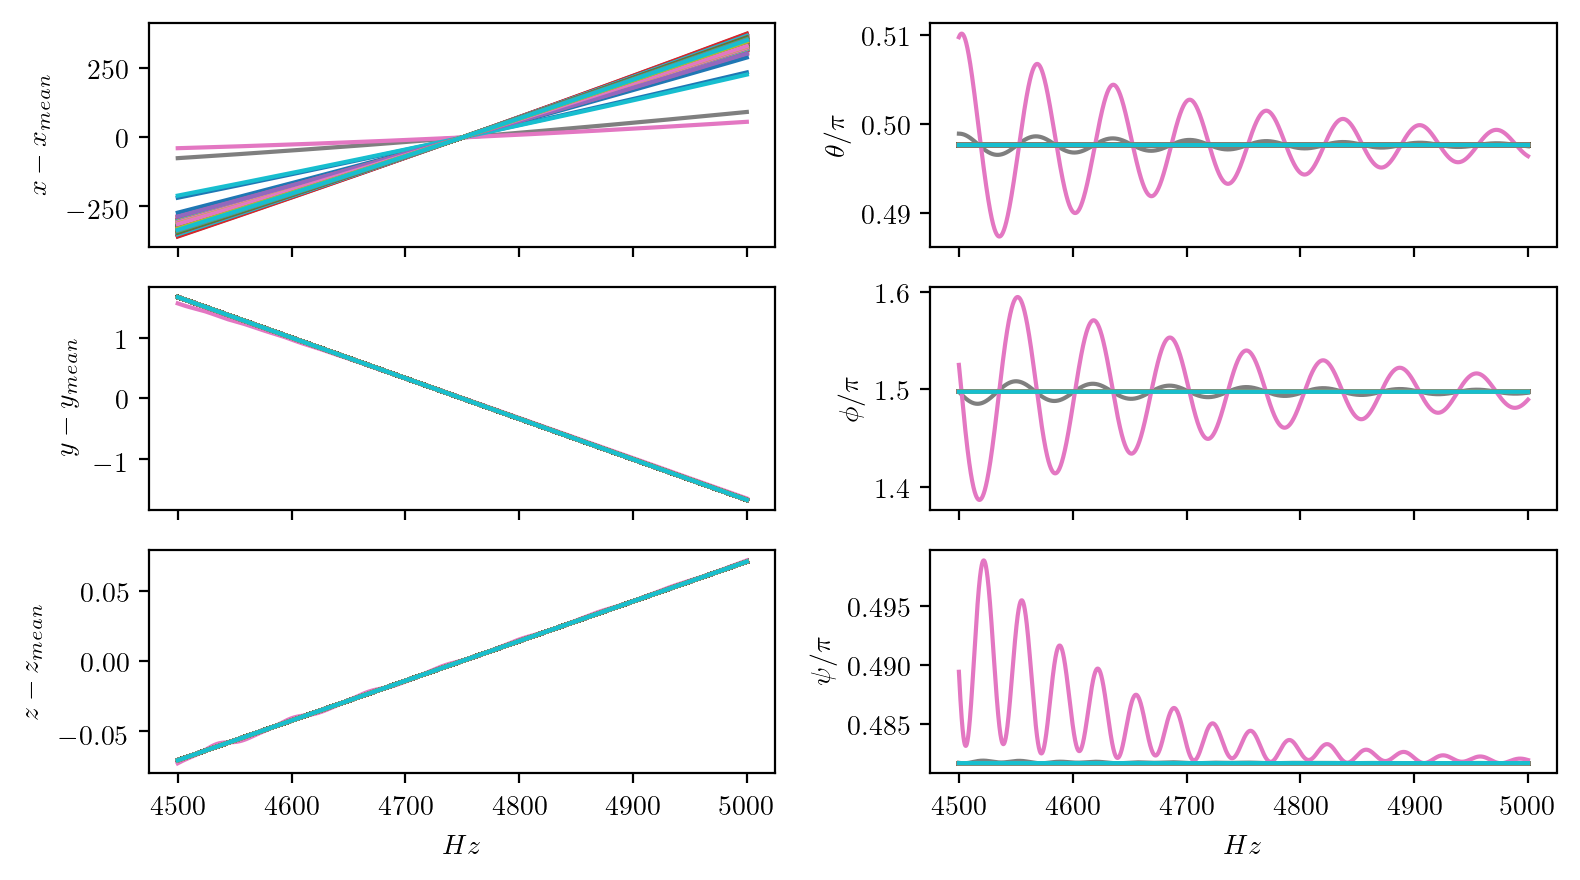

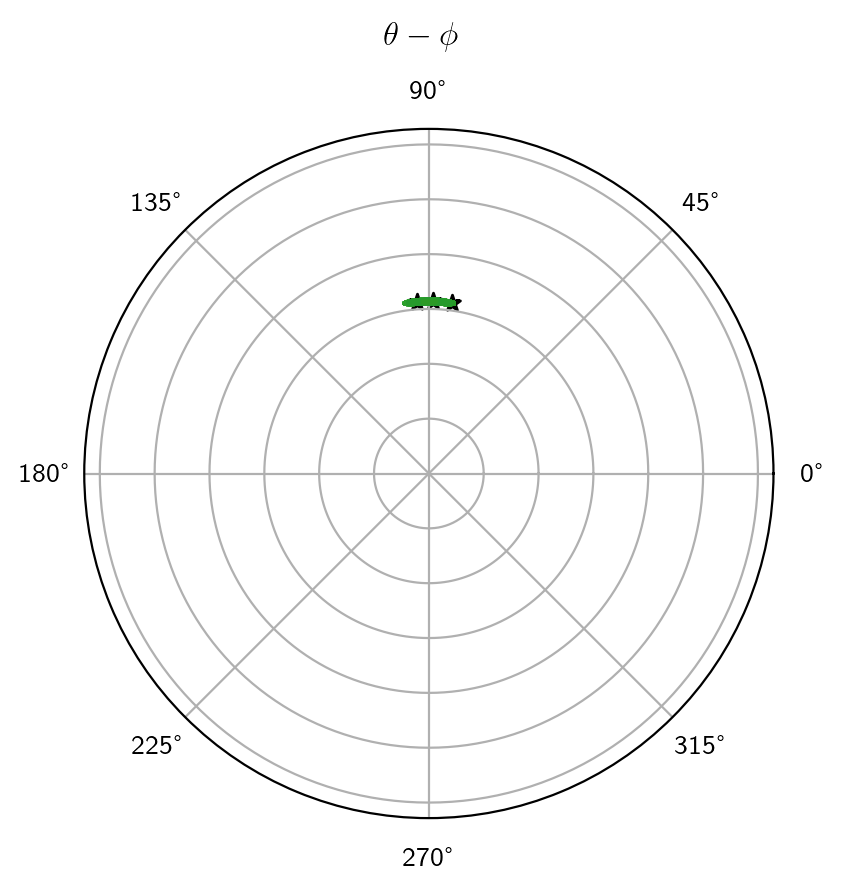

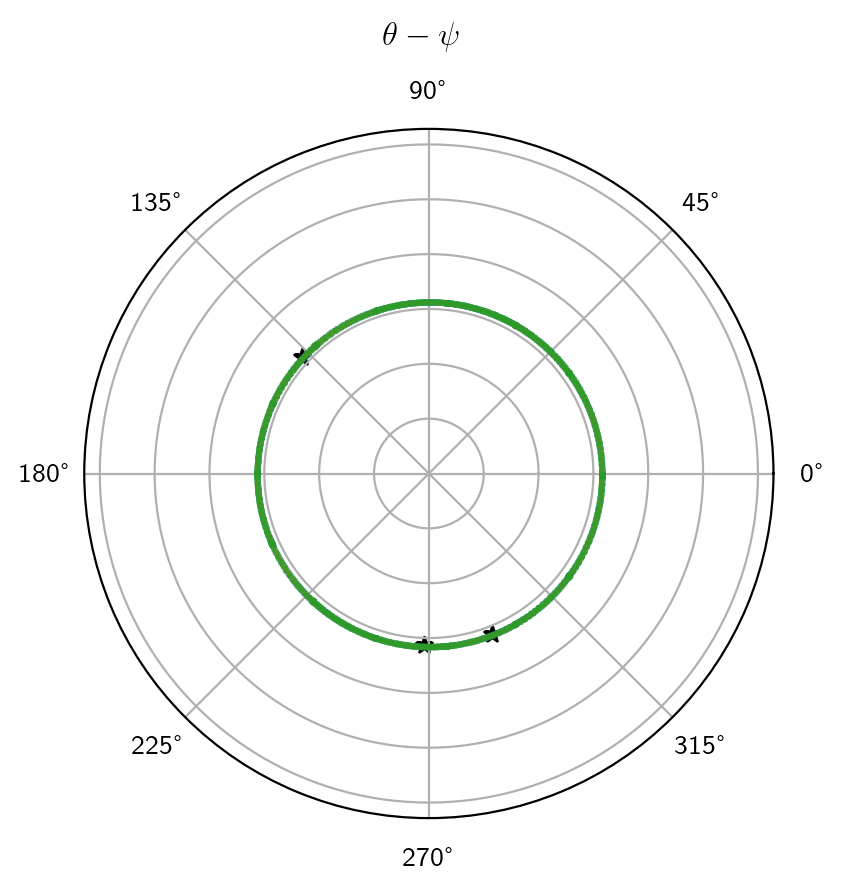

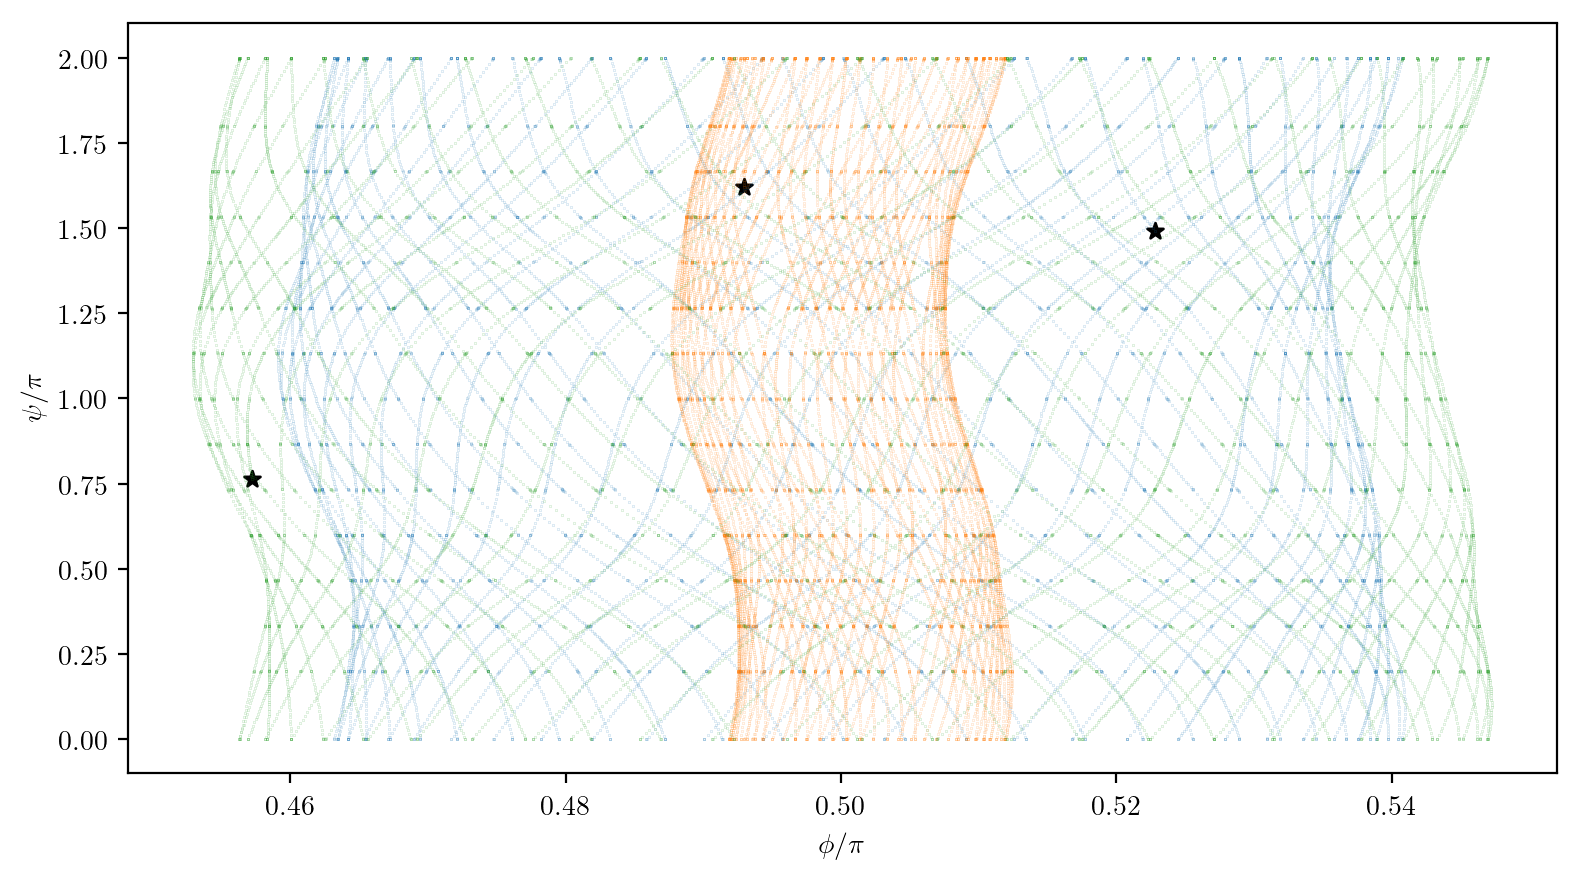

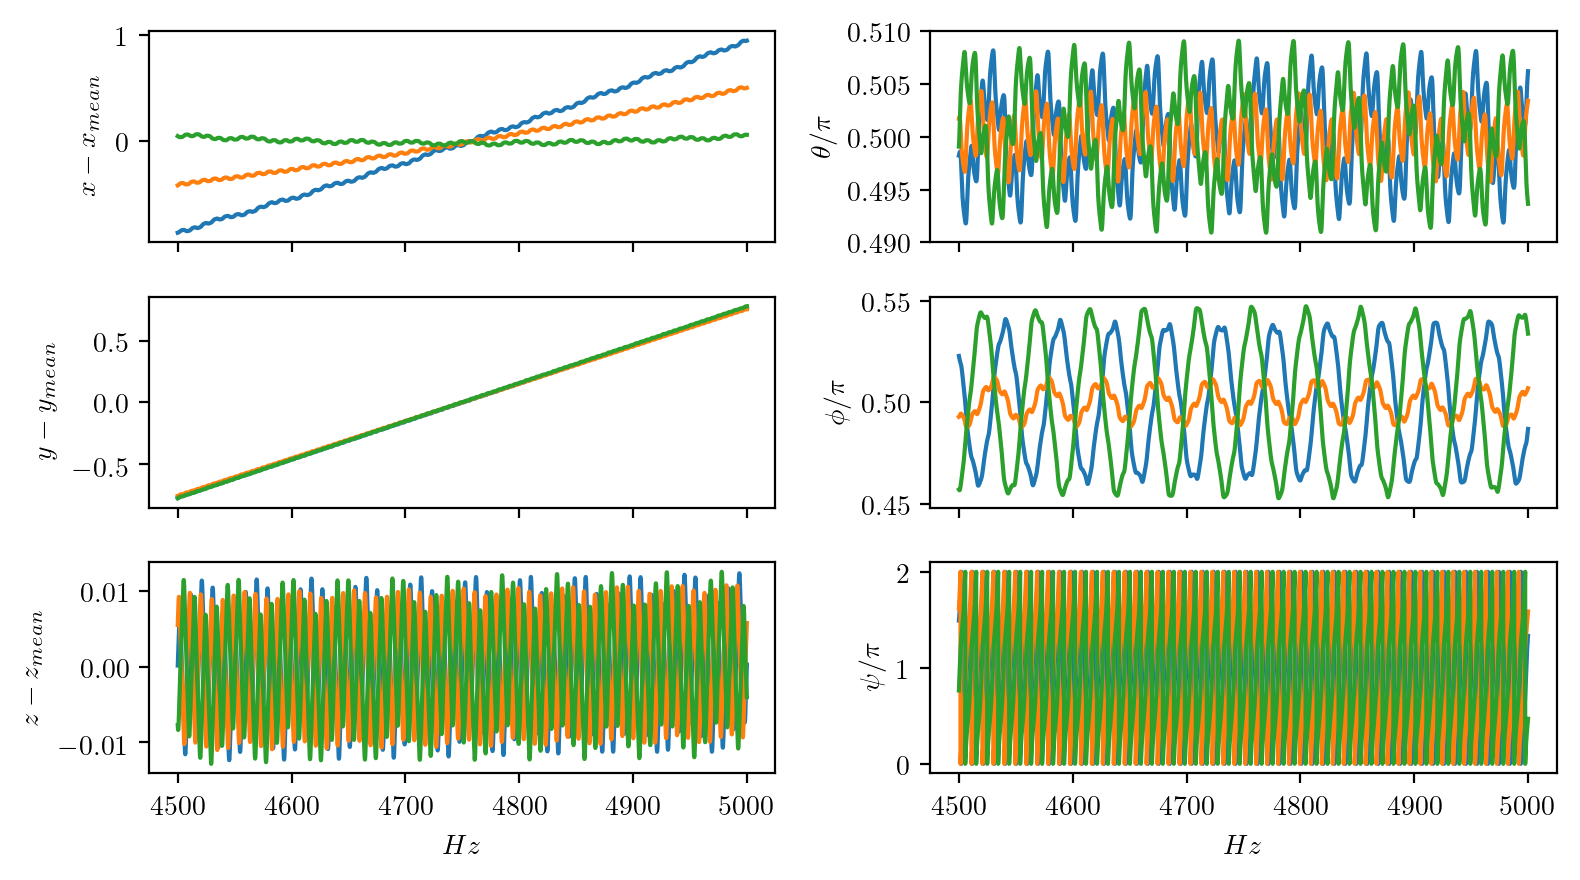

In [18]:
Table_t_range1 = np.array((4500, np.inf))
Table_t_range2 = np.array((4500, np.inf))
nshow = np.inf
# nshow = 2
fast_mode2 = True
figsize = np.array((16, 9)) * 0.5
dpi = 200

for i0 in np.arange(type_fre2.values.max() + 1)[:]:
    iidx = np.where(np.isclose(type_fre2.values, i0))
    spf_tb.phase_map_show_idx_list(type_fre2, iidx, job_dir, nshow=nshow, figsize=figsize, dpi=dpi, 
                                   Table_t_range1=Table_t_range1, Table_t_range2=Table_t_range2, fast_mode=fast_mode2, )

In [10]:
# for i0 in np.arange(type_fre2.values.max() + 1)[:]:
i0 = 1
Table_t_range = (4500, np.inf)

iidx = np.where(np.isclose(type_fre2.values, i0))
theta = type_fre.index.values[iidx[0]]
phi = type_fre.columns.values[iidx[1]]
theta_phi_list = np.vstack((theta, phi)).T
# print(theta_phi_list)

t1 = []
for theta, phi in tqdm_notebook(theta_phi_list):
    tpick, _ = spf_tb.load_table_date_pickle(job_dir, theta, phi)
    Table_t = tpick['Table_t']
    idx = np.logical_and(Table_t >= Table_t_range[0], Table_t <= Table_t_range[1])
    Table_theta = tpick['Table_theta'][idx]
    Table_phi = tpick['Table_phi'][idx]
    Table_psi = tpick['Table_psi'][idx]
    t2 = (np.max(Table_theta), np.min(Table_theta), np.mean(Table_theta), 
          np.max(Table_phi), np.min(Table_phi), Table_psi[np.argmax(Table_phi)], 
          np.max(Table_psi), np.min(Table_psi), np.mean(Table_psi), )
    t1.append(t2)

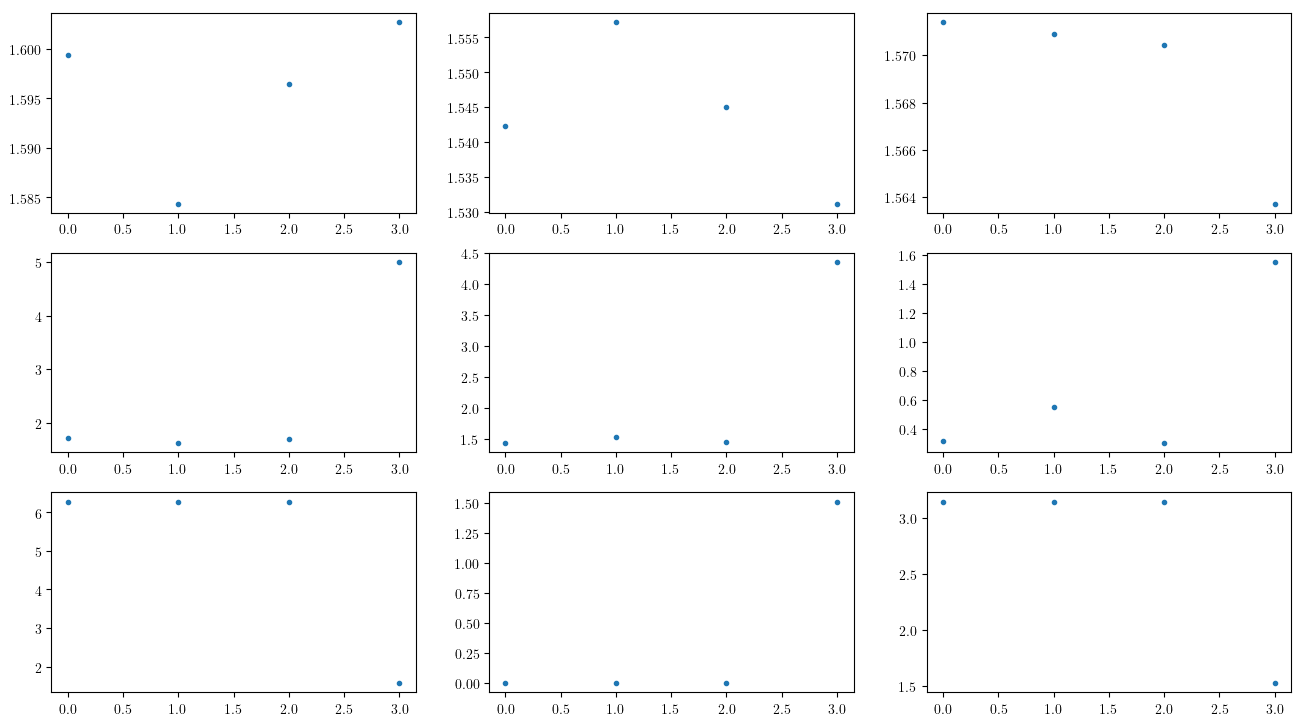

In [11]:
figsize = np.array((16, 9))
dpi = 100

t1 = np.vstack(t1)
# t1[t1[:, 3] > 5.1950, :] = np.nan 
fig, axs = plt.subplots(3, 3, figsize=figsize, dpi=dpi)
for i0, axi in enumerate(axs.ravel()):
#     print(t1[:, i0])
    axi.plot(t1[:, i0], '.')

True

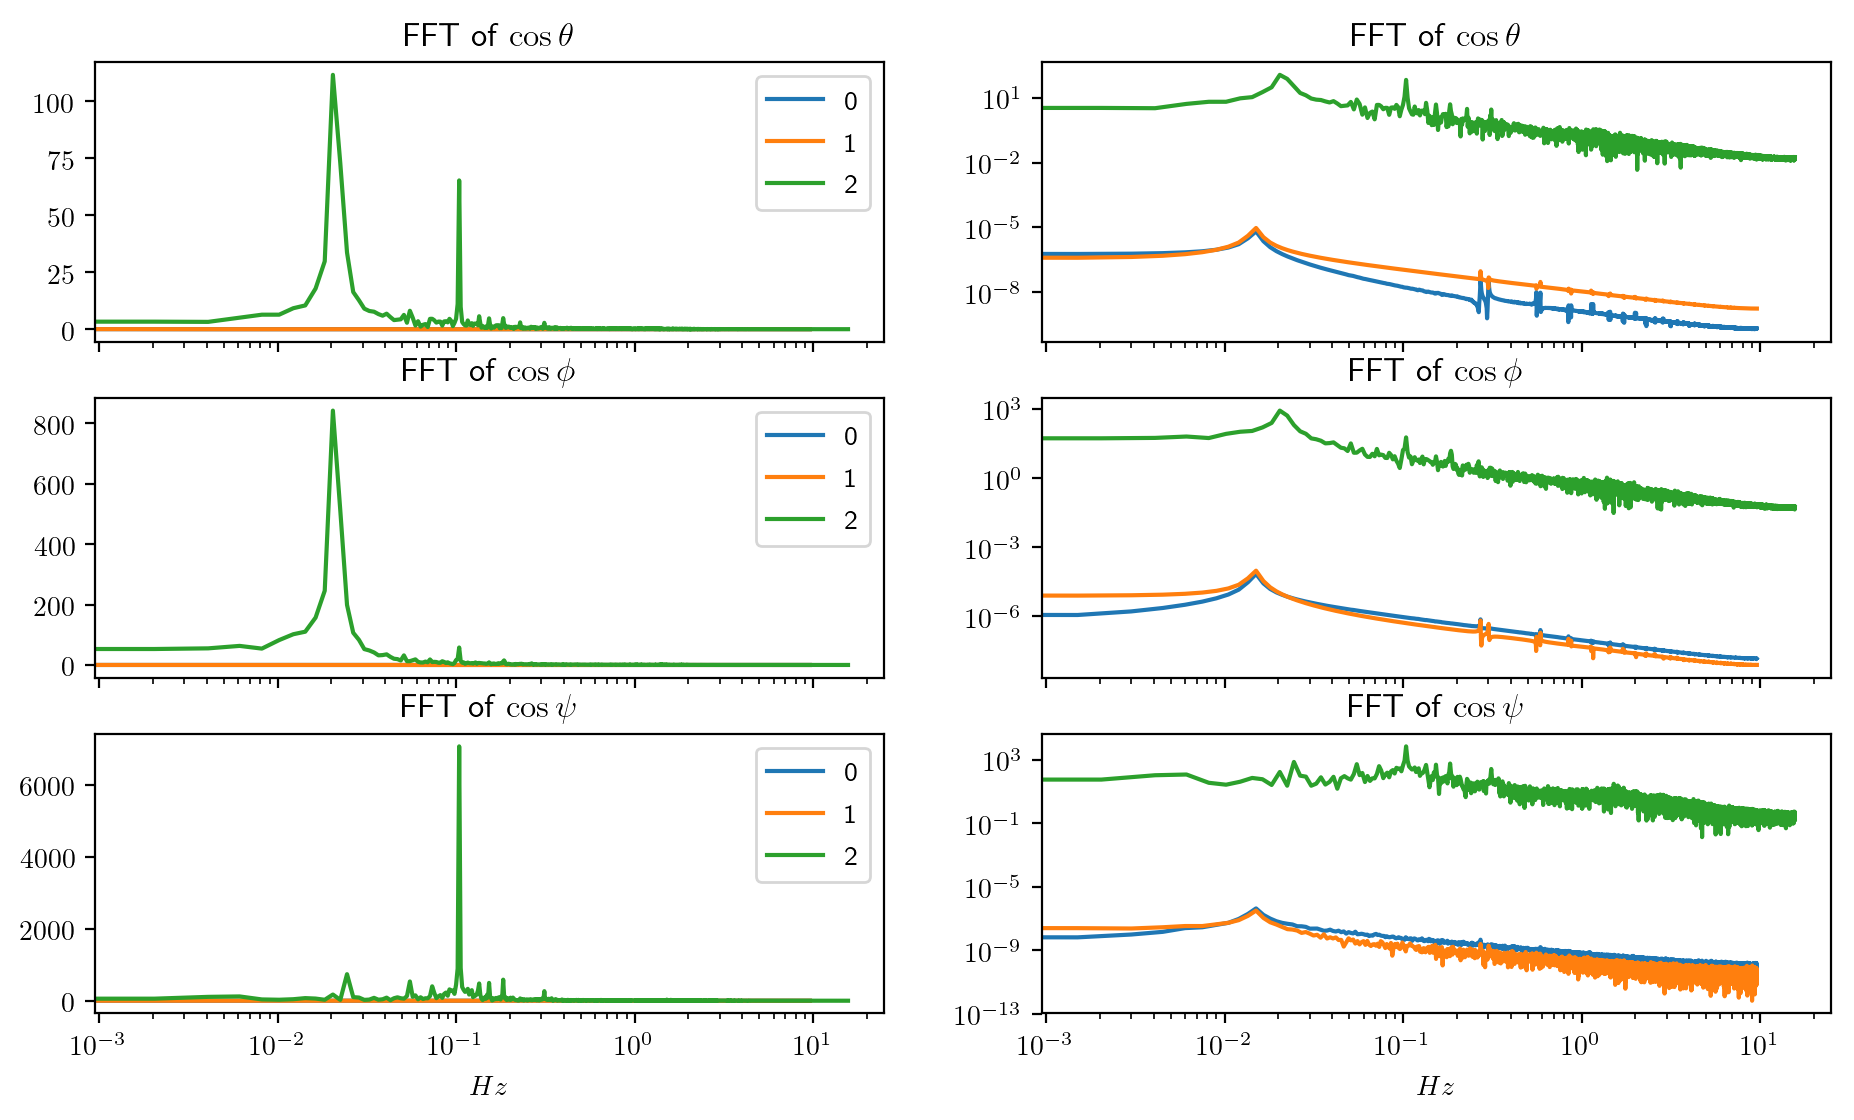

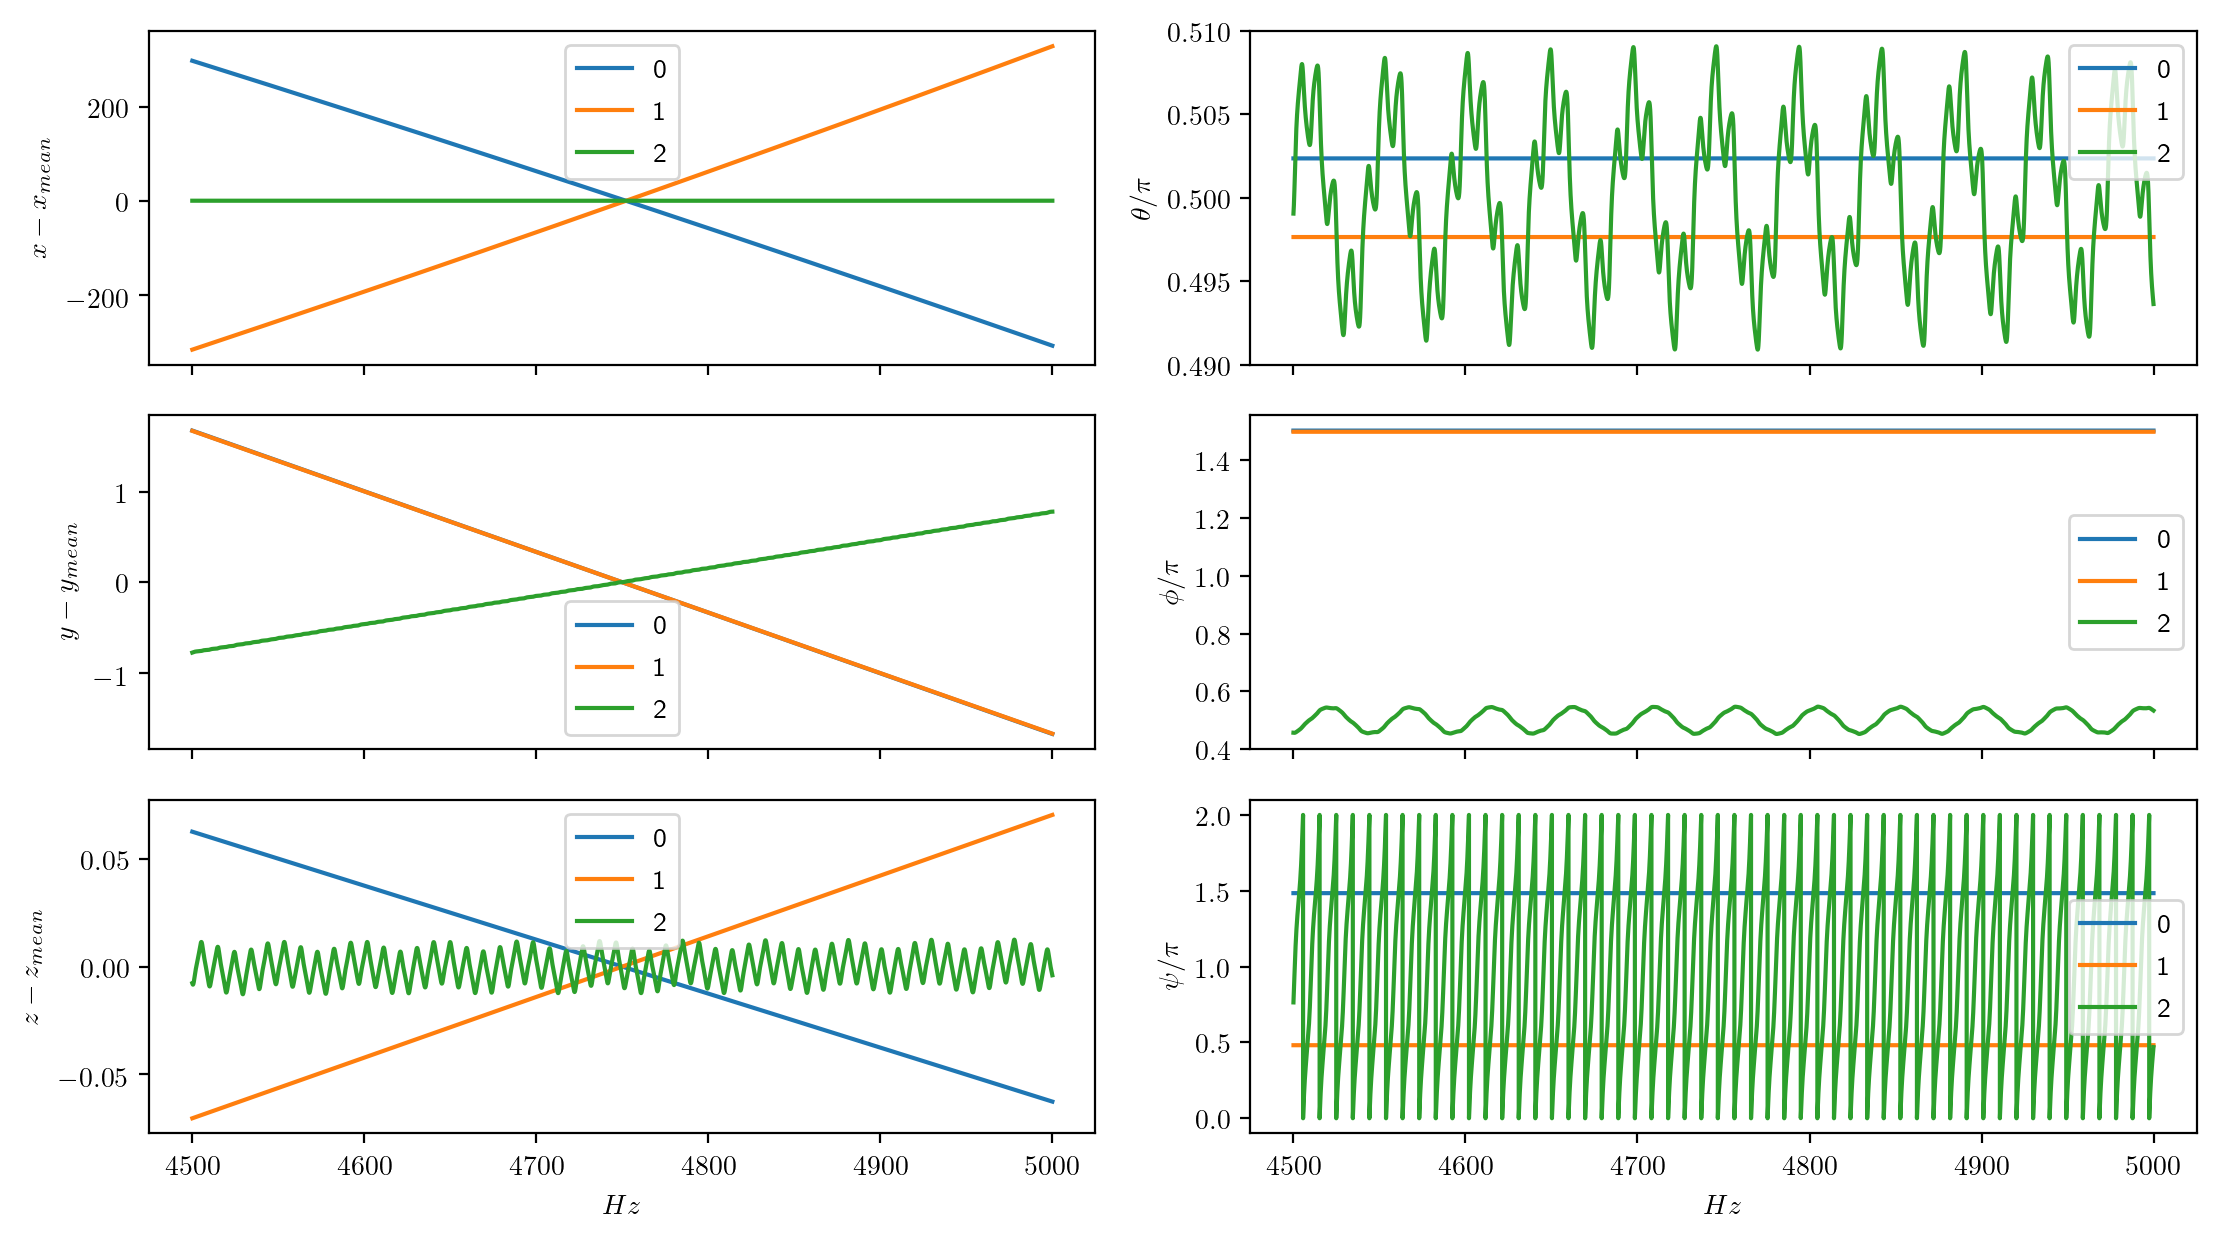

In [22]:
# tipical_th_ph_list = [[0.   , 1.714],
#        [0.000, 0.   ],
#        [0.143, 0.   ],
#        [0.143, 0.428],
#        [0.143, 0.571]]

tipical_th_ph_use_idx = [0, 1, 2]
Table_t_range = np.array((4500, np.inf))
figsize = np.array((16, 9)) * 0.7
dpi = 200

tipical_th_ph_list_use = np.array(tipical_th_ph_list)[tipical_th_ph_use_idx]
label_list = np.arange(len(tipical_th_ph_list))[tipical_th_ph_use_idx]
spf_tb.show_table_theta_phi_psi_fft_list(tipical_th_ph_list_use, job_dir, label_list=label_list, figsize=figsize, dpi=dpi)
spf_tb.show_table_result_list(tipical_th_ph_list_use, job_dir, label_list=label_list, Table_t_range=Table_t_range,
                              figsize=figsize, dpi=dpi)

In [8]:
psi_lim_fct = 20
resampling_fct = 10
figsize = np.array((16, 9)) * 0.7
dpi = 200

# case_path_list = separate_fre_path_v2(type_fre2)
# color_list =     [np.array(plt.get_cmap('tab20', len(check_fre_list))(i0)[:3]).reshape((1, 3)) 
#                   for i0 in np.arange(type_fre2.values.max() + 1)]
for idx, psi_lim1 in enumerate(np.linspace(0, 2 * np.pi, psi_lim_fct * 16, endpoint=False)[::psi_lim_fct]):
    psi_lim = (psi_lim1, psi_lim1 + 2 * np.pi / (psi_lim_fct * 16))
    # create fig
    desc = '$\\psi \\in [%.3f \\pi, %.3f \\pi)$' % ((psi_lim[0] / np.pi), (psi_lim[1] / np.pi))
    fig, ax1 = plt.subplots(1, 1, figsize=figsize, dpi=dpi, subplot_kw=dict(polar=True))
    n_xticks = 32
    xticks = np.arange(n_xticks)
    ax1.set_xticks(xticks / n_xticks * 2 * np.pi)
    ax1.set_xticklabels(['$\dfrac{%d}{%d}2\pi$' % (i0, n_xticks) for i0 in xticks])
    ax1.set_yticklabels([])
    ax1.set_ylim(0, np.pi)
    fig.suptitle(desc)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    
    for i0 in np.arange(type_fre2.values.max() + 1):
        # get case_path
        iidx = np.where(np.isclose(type_fre2.values, i0))
        theta = type_fre2.index.values[iidx[0]]
        phi = type_fre2.columns.values[iidx[1]]
        theta_phi_list = np.vstack((theta, phi)).T
        case_path = []
        for theta, phi in theta_phi_list[:]:
            t_headle = 'th%5.3f_ph%5.3f_(.*?).pickle' % (theta, phi)
            filename = [filename for filename in os.listdir(job_dir)
                        if re.match(t_headle, filename) is not None][0]
            case_path.append(os.path.join(PWD, job_dir, filename))
            
        thandle = ''
        color = np.array(plt.get_cmap('tab20', int(type_fre2.values.max() + 1))(int(i0))[:3]).reshape((1, 3)) 
#         print(int(type_fre2.values.max()), i0, color)
        spf_tb.draw_phase_map_theta(case_path, color, psi_lim, axs=[ax1, ], thandle=thandle, 
                                    resampling=True, resampling_fct=resampling_fct)
    tdir = os.path.join(PWD, job_dir, 'phase_mape_fre')
    if not os.path.exists(tdir):
        os.makedirs(tdir)
    figname = os.path.join(tdir, '%04d.png' % (idx))
    fig.savefig(os.path.join(tdir, figname))
    print('save to %s' % figname)
    plt.close(fig)


save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_wt0.9_psi-0a/phase_mape_fre/0000.png



save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_wt0.9_psi-0a/phase_mape_fre/0001.png



save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_wt0.9_psi-0a/phase_mape_fre/0002.png



save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_wt0.9_psi-0a/phase_mape_fre/0003.png



save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_wt0.9_psi-0a/phase_mape_fre/0004.png



save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_wt0.9_psi-0a/phase_mape_fre/0005.png



save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_wt0.9_psi-0a/phase_mape_fre/0006.png



save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_wt0.9_psi-0a/phase_mape_fre/0007.png



save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_wt0.9_psi-0a/phase_mape_fre/0008.png



save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_wt0.9_psi-0a/phase_mape_fre/0009.png



save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_wt0.9_psi-0a/phase_mape_fre/0010.png



save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_wt0.9_psi-0a/phase_mape_fre/0011.png



save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_wt0.9_psi-0a/phase_mape_fre/0012.png



save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_wt0.9_psi-0a/phase_mape_fre/0013.png



save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_wt0.9_psi-0a/phase_mape_fre/0014.png



save to /home/zhangji/stokes_flow_master/head_Force/do_calculate_table/ecoC01B05_wt0.9_psi-0a/phase_mape_fre/0015.png


In [ ]:
psi_lim_fct = 20
resampling_fct = 10
figsize = np.array((16, 9)) * 0.7
dpi = 200

# case_path_list = separate_fre_path_v2(type_fre2)
# color_list =     [np.array(plt.get_cmap('tab20', len(check_fre_list))(i0)[:3]).reshape((1, 3)) 
#                   for i0 in np.arange(type_fre2.values.max() + 1)]
for idx, psi_lim1 in enumerate(np.linspace(0, 2 * np.pi, psi_lim_fct * 16, endpoint=False)[:1:psi_lim_fct]):
    psi_lim = (psi_lim1, psi_lim1 + 2 * np.pi / (psi_lim_fct * 16))
    # create fig
    desc = '$\\psi \\in [%.3f \\pi, %.3f \\pi)$' % ((psi_lim[0] / np.pi), (psi_lim[1] / np.pi))
    fig, ax1 = plt.subplots(1, 1, figsize=figsize, dpi=dpi, subplot_kw=dict(polar=True))
    n_xticks = 32
    xticks = np.arange(n_xticks)
    ax1.set_xticks(xticks / n_xticks * 2 * np.pi)
    ax1.set_xticklabels(['$\dfrac{%d}{%d}2\pi$' % (i0, n_xticks) for i0 in xticks])
    ax1.set_yticklabels([])
    ax1.set_ylim(0, np.pi)
    fig.suptitle(desc)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    
    for i0 in np.arange(type_fre2.values.max() + 1):
        # get case_path
        iidx = np.where(np.isclose(type_fre2.values, i0))
        theta = type_fre2.index.values[iidx[0]]
        phi = type_fre2.columns.values[iidx[1]]
        theta_phi_list = np.vstack((theta, phi)).T
        case_path = []
        for theta, phi in theta_phi_list[:]:
            t_headle = 'th%5.3f_ph%5.3f_(.*?).pickle' % (theta, phi)
            filename = [filename for filename in os.listdir(job_dir)
                        if re.match(t_headle, filename) is not None][0]
            case_path.append(os.path.join(PWD, job_dir, filename))
            
        thandle = ''
        color = np.array(plt.get_cmap('tab20', int(type_fre2.values.max() + 1))(int(i0))[:3]).reshape((1, 3)) 
#         print(int(type_fre2.values.max()), i0, color)
        spf_tb.draw_phase_map_theta_bck(case_path, color, psi_lim, axs=[ax1, ], thandle=thandle, 
                                    resampling=True, resampling_fct=resampling_fct)
    tdir = os.path.join(PWD, job_dir, 'phase_mape_freb')
    if not os.path.exists(tdir):
        os.makedirs(tdir)
    figname = os.path.join(tdir, '%04d.png' % (idx))
    fig.savefig(os.path.join(tdir, figname))
    print('save to %s' % figname)
    plt.close(fig)